In [57]:
import os
from os.path import exists

import re
import numpy as np

import pandas as pd 
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Ragas grouped by Rasas

In [59]:
path_rasa_list = '../ComputationalMusicology-TheRagaGuide/RagaList.xlsx'
raga_rasa = pd.read_excel(path_rasa_list)[['Raga', 'FileName', 'Rasa', 'ALT_Rasa']]

display(raga_rasa)
display(raga_rasa.groupby(['Rasa']).count().sort_values('Raga', ascending=False))
display(raga_rasa.groupby(['ALT_Rasa']).count().sort_values('Raga', ascending=False))



,Raga,FileName,Rasa,ALT_Rasa
0,Abhogi,Abhogi_D1T1.txt,Virah,Karuna
1,Adana,Adana_D1T2.txt,Veer,Veer
2,Ahir Bhairav,Ahir_bhairav_D1T3.txt,Bhakti,Bhakti
3,Alhaiya bilaval,Alhaiya_bilaval_D1T4.txt,Adbhut,Adbhut
4,Asavari,Asavari_D1T5.txt,Bhakti,Bhakti
...,...,...,...,...
69,Sohini,sohini.txt,Karuna,Karuna
70,Sur Malhar,sur_malhar.txt,Adbhut,Adbhut
71,Tilak Kamod,tilak_kamod.txt,Hasya,Hasya
72,Tilang,tilang.txt,Shringar,Shringar


,Raga,FileName,ALT_Rasa
Rasa,,,
Shringar,33,33,33
Bhakti,11,11,11
Karuna,7,7,7
Adbhut,5,5,5
Veer,5,5,5
Raudra,4,4,4
Virah,3,3,3
Hasya,2,2,2
Shaant,2,2,2


,Raga,FileName,Rasa
ALT_Rasa,,,
Shringar,22,22,22
Bhakti,21,21,21
Karuna,14,14,14
Raudra,7,7,7
Adbhut,5,5,5
Veer,3,3,3
Hasya,2,2,2


Q#1: A basic distribution of a main variable of interest in your corpus (e.g., distribution of works by year, distribution of tempi, distribution of phrase lengths, distribution of chord types, etc.) You may additionally wish to add a grouping variable to this distribution (e.g., perhaps there are two composers; major versus minor keys; etc.) This latter condition is optional. \

Ans: We are studying the melodic similarities among ragas of the same rasa. Our main variable of interest is the notes or swaras. We choose the scale degree (swara) distribution of each raga within a rasa and plot the correlation matrix between the distributions of all the ragas. \ 
Since the dataset is unbalanced (shringar rasa consisting 33 ragas), we intend to choose the most correlated ragas representative of the shringar rasa. We choose the top five rasas to depict correlation matrices of.\
For scale degree we actually build a scale as an array consisting of 12 pitches in an octave. We are aware that since most ragas have a maximum of 8 or 9 notes, that some 0s in the chromatic scale array might bump up the correlation coefficient value.


In [105]:
#utility functions

def get_token_tallies(file):
    if exists(file)==False:
        return -1
    with open(file, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i].strip()
    return lines
    
def plot_hist(file_with_lines):
    
    w = Counter(file_with_lines)
    w = OrderedDict(sorted(w.items()))
    
    plt.rcParams["figure.figsize"] = (20,3)
    plt.bar(w.keys(), w.values())
    plt.show()

def make_corr_arrays(file_with_lines):
    scale = ['1', '2-', '2', '3-', '3', '4', '4+', '5', '6-', '6', '7-', '7']
    w = Counter(file_with_lines)
    scale_degree_frequency=np.zeros(12)
    for i in range(len(scale)):
        if scale[i] in w.keys():
            scale_degree_frequency[i] = w[scale[i]]
        
    return scale_degree_frequency.astype(int)

def get_swara_distribution_per_raga(rasa_dataframe):
    raga_names = []
    rasa_swara_distribution_per_raga = np.empty((len(rasa_dataframe), 12))

    for i in rasa_dataframe.index:
        path = 'Analysis/deg_files/'+str(rasa_dataframe['FileName'].loc[i])+'.deg'
        rasa_lines = get_token_tallies(path)
        if rasa_lines == -1:
            print(f"file:{rasa_dataframe['FileName'].loc[i]} doesn't exist")
            continue
        raga_names.append(rasa_dataframe['Raga'].loc[i])
        rasa_lines = [line for line in rasa_lines if not re.search(r'[*]', line)]
        scale_deg_dist_rasa = make_corr_arrays(rasa_lines)
#         print('scale_deg_dist_rasa', scale_deg_dist_rasa)
        rasa_swara_distribution_per_raga[i] = scale_deg_dist_rasa
    return rasa_swara_distribution_per_raga, raga_names

def get_n_grams_from_raga_lines(raga_lines, n):
    n_grams = []
    for index, raga_line in enumerate(raga_lines):
        if index >= n - 1:
            n_grams.append(raga_lines[index - n + 1: index + 1])
    return n_grams
            

def get_n_grams_per_raga(rasa_dataframe, n=2):
    deg_to_index_mapping = {
        '1': 0,
        '2-': 1,
        '2': 2,
        '3-': 3,
        '3': 4,
        '4': 5,
        '4+': 6,
        '5': 7,
        '6-': 8,
        '6': 9,
        '7-': 10,
        '7': 11
    }
    raga_names = []
    rasa_swara_distribution_per_raga = np.empty((len(rasa_dataframe), pow(12, n)))

    for i in rasa_dataframe.index:
        path = 'Analysis/deg_files/'+str(rasa_dataframe['FileName'].loc[i])+'.deg'
        rasa_lines = get_token_tallies(path)
        if rasa_lines == -1:
            print(f"file:{rasa_dataframe['FileName'].loc[i]} doesn't exist")
            continue
        raga_names.append(rasa_dataframe['Raga'].loc[i])
        rasa_lines = [line for line in rasa_lines if not re.search(r'[*]', line) and line in deg_to_index_mapping.keys()]
        n_grams = get_n_grams_from_raga_lines(rasa_lines, n)
        n_gram_distribution = np.zeros(pow(12, n))
        for n_gram in n_grams:
            n_gram_distribution_index = 0
            for i in range(n):
                n_gram_distribution_index += deg_to_index_mapping[n_gram[i]] * pow(12, i)
            n_gram_distribution[n_gram_distribution_index] += 1
        rasa_swara_distribution_per_raga[i] = n_gram_distribution
    return rasa_swara_distribution_per_raga, raga_names

### Virah

In [61]:
virah = raga_rasa[raga_rasa['Rasa'] == 'Virah'].reset_index()[['Raga', 'FileName', 'Rasa']]
virah

,Raga,FileName,Rasa
0,Abhogi,Abhogi_D1T1.txt,Virah
1,Desh,Desh_D2T4.txt,Virah
2,Patdip,Patdip_D3T19.txt,Virah


# Adbhut

,Raga,FileName,Rasa
0,Alhaiya bilaval,Alhaiya_bilaval_D1T4.txt,Adbhut
1,Bahar,Bahar_D1T7.txt,Adbhut
2,Basant,Basant_D1T8.txt,Adbhut
3,Miyan ki Malhar,Miyan_ki_malhar_D3T15.txt,Adbhut
4,Sur Malhar,sur_malhar.txt,Adbhut


Text(114.0, 0.5, 'Ragas')

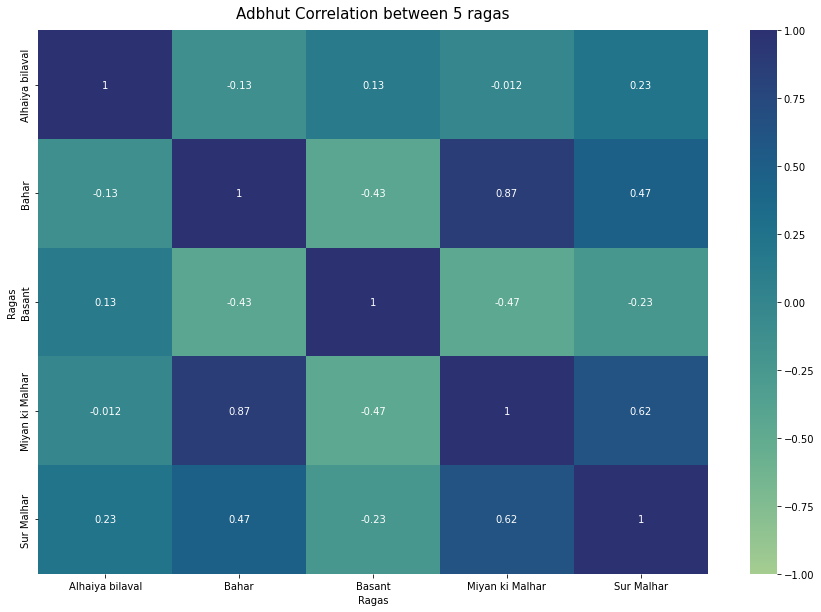

In [62]:
adbhut = raga_rasa[raga_rasa['Rasa'] == 'Adbhut'].reset_index()[['Raga', 'FileName', 'Rasa']]
display(adbhut)
adbhut_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(adbhut)
R1 = np.corrcoef(adbhut_swara_distribution_per_raga)
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(R1, annot=True, vmin=-1, vmax=1, 
                      cmap="crest", 
                      xticklabels=raga_names,
                      yticklabels=raga_names);
title = 'Adbhut Correlation between ' + str(len(raga_names)) + ' ragas'


heatmap.set_title(title,
                  fontdict={'fontsize':15}, pad=12);


heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

In [101]:
len(np.arange(0,12,1))
len(scale)
adbhut_swara_distribution_per_raga, raga_names

(array([[ 3.,  0.,  4.,  0.,  7.,  1.,  0.,  3.,  0.,  3.,  0.,  1.],
        [16.,  0.,  6., 17.,  0., 19.,  0., 12.,  0.,  6., 13.,  5.],
        [30., 20.,  0.,  0., 22.,  2., 23.,  9., 16.,  0.,  0., 17.],
        [14.,  0., 12.,  8.,  0., 19.,  0.,  7.,  0.,  6., 13.,  6.],
        [23.,  0., 32.,  0.,  0., 44.,  0., 41.,  0., 17.,  0., 32.]]),
 ['Alhaiya bilaval', 'Bahar', 'Basant', 'Miyan ki Malhar', 'Sur Malhar'])

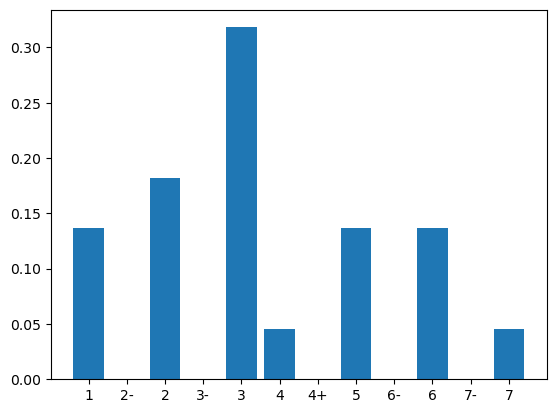

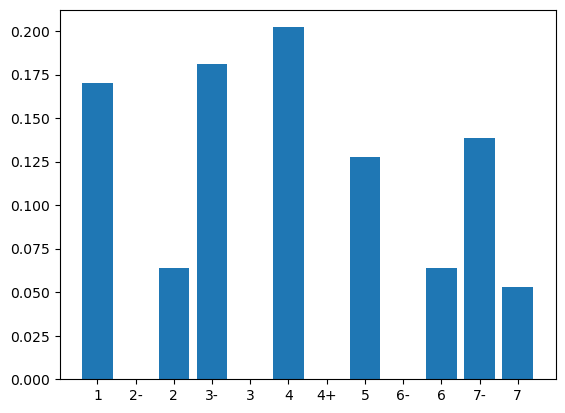

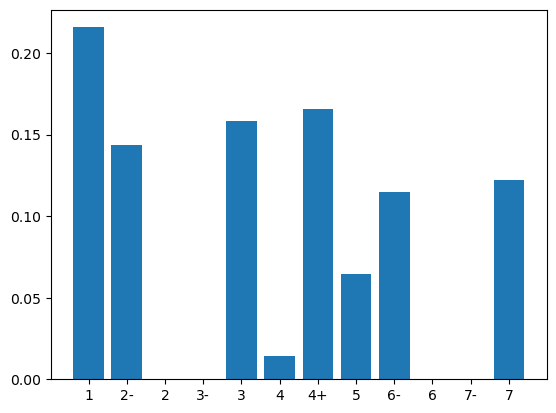

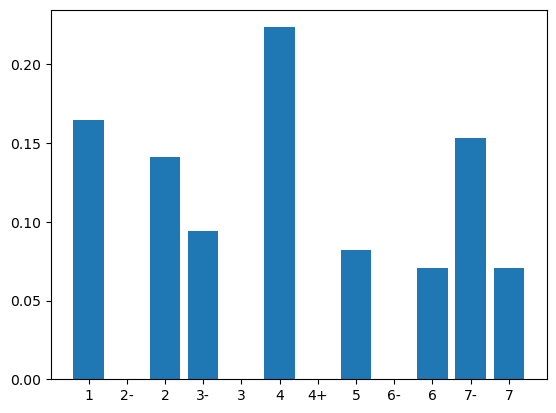

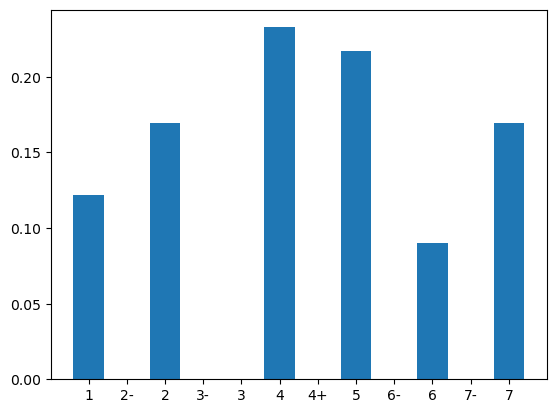

In [96]:
norm=[]
for i in range(len(adbhut_swara_distribution_per_raga)):
    norm.append(adbhut_swara_distribution_per_raga[i]/sum(adbhut_swara_distribution_per_raga[i]))
norm
plt.xticks(np.arange(0,12,1), scale)

plt.bar(np.arange(0,12,1),norm[0])
plt.xticks(np.arange(0,12,1), scale)

plt.show()
plt.bar(np.arange(0,12,1),norm[1])
plt.xticks(np.arange(0,12,1), scale)

plt.show()
plt.bar(np.arange(0,12,1),norm[2])
plt.xticks(np.arange(0,12,1), scale)

plt.show()
plt.bar(np.arange(0,12,1),norm[3])
plt.xticks(np.arange(0,12,1), scale)

plt.show()
plt.bar(np.arange(0,12,1),norm[4])
plt.xticks(np.arange(0,12,1), scale)

plt.show()



In [100]:
adbhut['Raga']

0    Alhaiya bilaval
1              Bahar
2             Basant
3    Miyan ki Malhar
4         Sur Malhar
Name: Raga, dtype: object

In [99]:
dict_adata = {'raga':a }
adbhut_df = pd.DataFrame()

                         
                         

,Raga,FileName,Rasa
0,Alhaiya bilaval,Alhaiya_bilaval_D1T4.txt,Adbhut
1,Bahar,Bahar_D1T7.txt,Adbhut
2,Basant,Basant_D1T8.txt,Adbhut
3,Miyan ki Malhar,Miyan_ki_malhar_D3T15.txt,Adbhut
4,Sur Malhar,sur_malhar.txt,Adbhut


In [106]:
adbhut_swara_distribution_per_raga[0]/100,adbhut_swara_distribution_per_raga[1]/100

(array([0.03, 0.  , 0.04, 0.  , 0.07, 0.01, 0.  , 0.03, 0.  , 0.03, 0.  ,
        0.01]),
 array([0.16, 0.  , 0.06, 0.17, 0.  , 0.19, 0.  , 0.12, 0.  , 0.06, 0.13,
        0.05]))

In [139]:
# adbhut_swara_distribution_per_raga
import scipy
scipy.special.kl_div(adbhut_swara_distribution_per_raga[0]/100, 
                     adbhut_swara_distribution_per_raga[1]/100)

array([0.07978071, 0.        , 0.0037814 , 0.17      ,        inf,
       0.15055561, 0.        , 0.04841117, 0.        , 0.00920558,
       0.13      , 0.02390562])

# Shringar

,Raga,FileName,Rasa
0,Bageshri,Bageshri_D1T6.txt,Shringar
1,Bhimpalasi,Bhimpalasi_D1T12.txt,Shringar
2,Bihag,Bihag_D1T16.txt,Shringar
3,Brindabani Sarang,Brindabani_sarang_D1T18.txt,Shringar
4,Chandrakauns,Chandrakauns_D2T1.txt,Shringar
5,Darbari Kanada,Darbari_kanada_D2T3.txt,Shringar
6,Deshi,Deshi_D2T5.txt,Shringar
7,Durga,Durga_D2T7.txt,Shringar
8,Gaud Malhar,Gaud_malhar_D2T8.txt,Shringar
9,Gaud Sarang,Gaud_sarang_D2T9.txt,Shringar


Text(222.72222222222223, 0.5, 'Ragas')

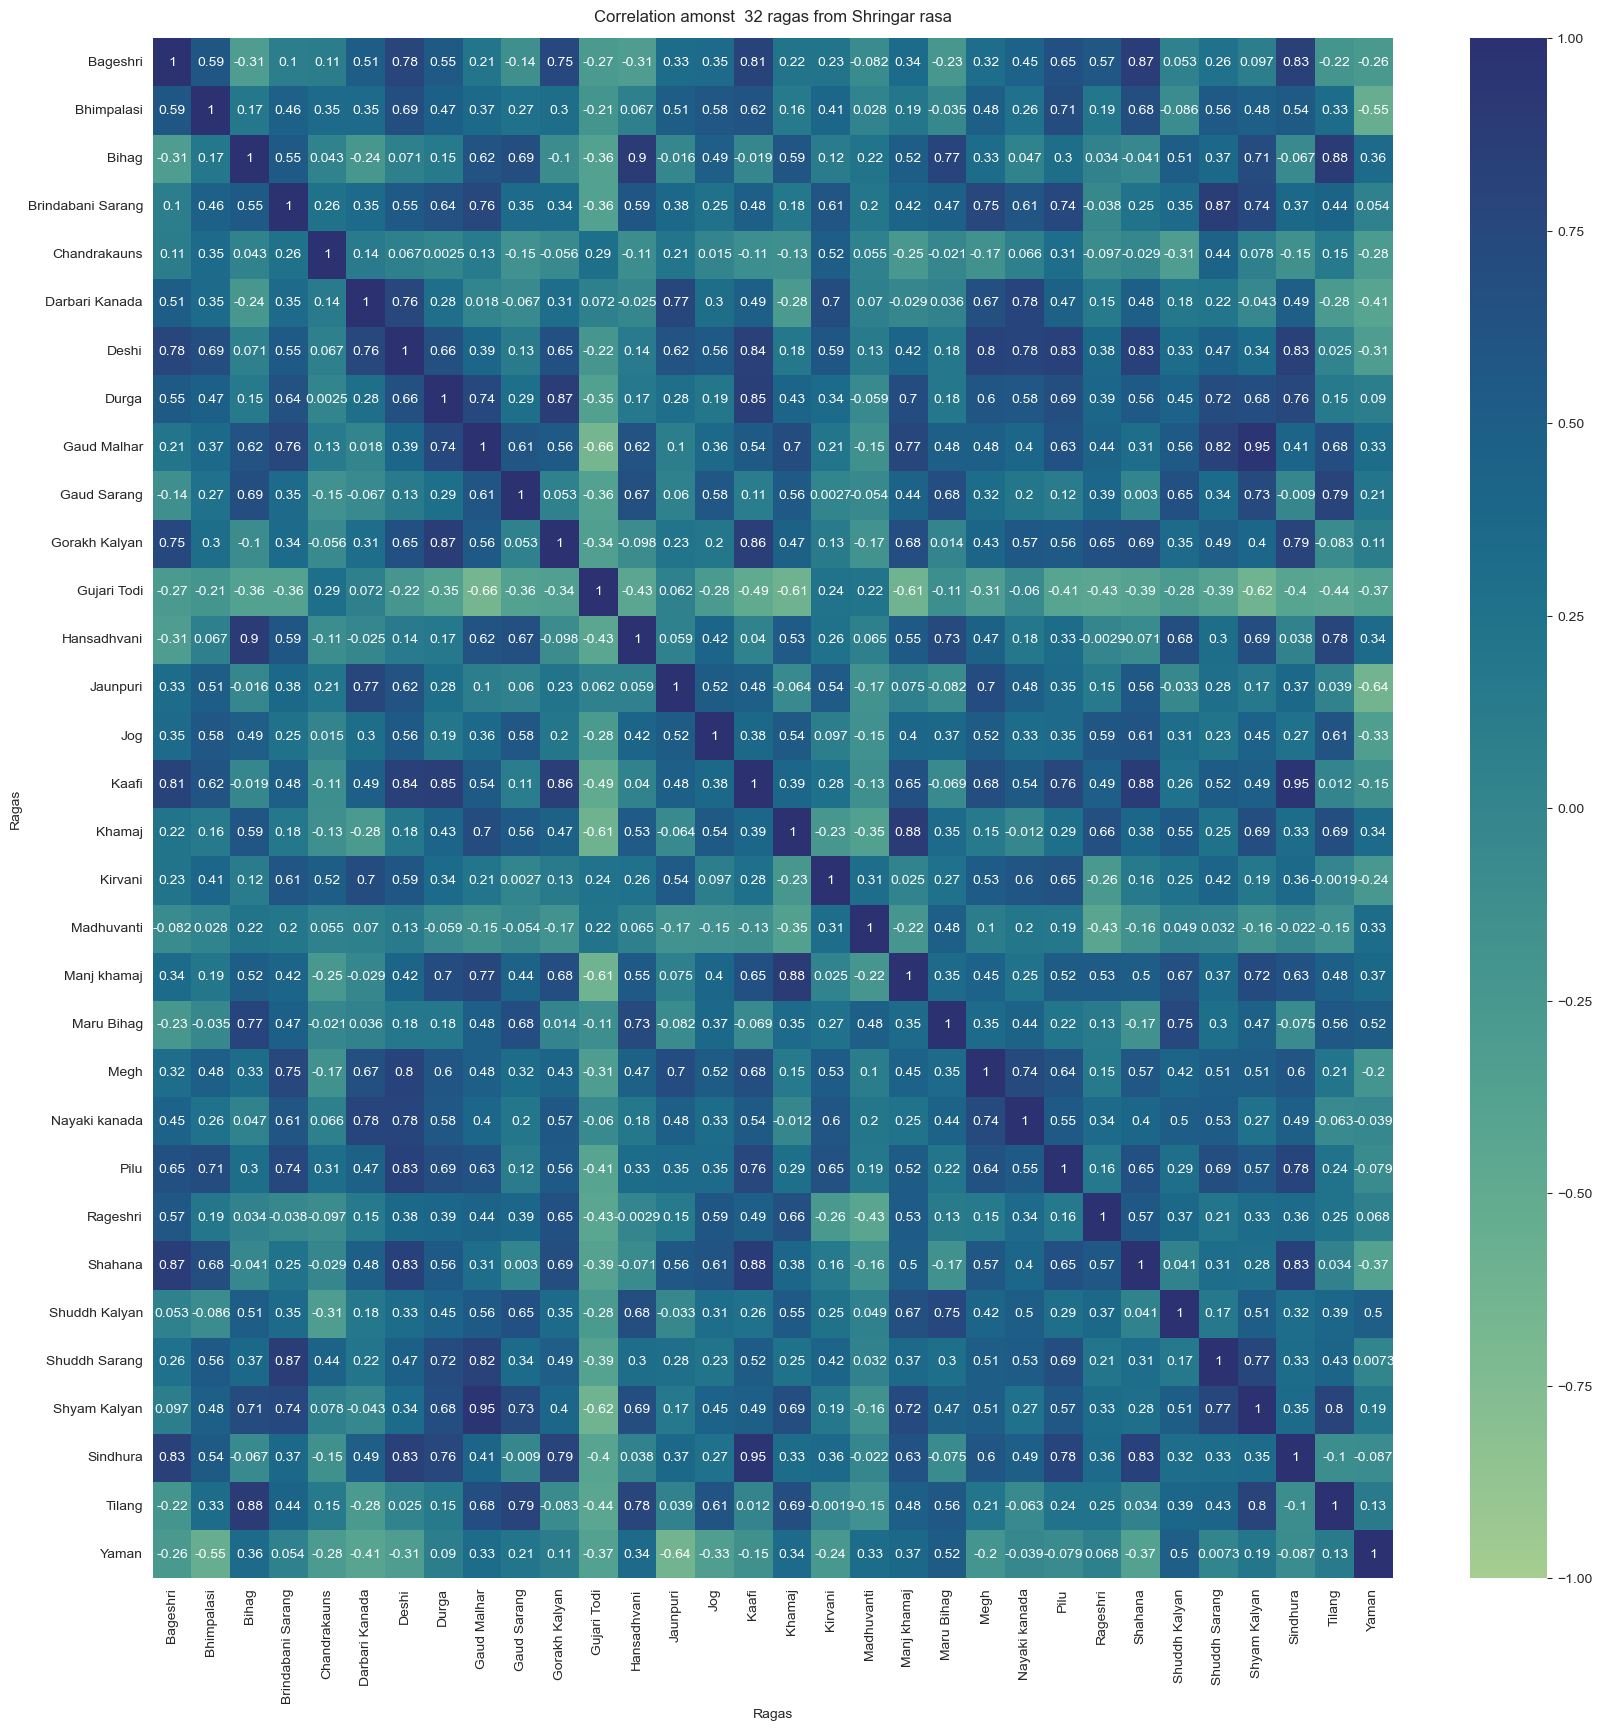

In [206]:
#Shringar or love

shringar = raga_rasa[raga_rasa['Rasa'] == 'Shringar'].reset_index().drop(index=14).reset_index()[['Raga', 'FileName', 'Rasa']]

display(shringar)
shringar_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(shringar)
R1 = np.corrcoef(shringar_swara_distribution_per_raga)
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(R1, annot=True, vmin=-1, vmax=1, 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);
title = 'Correlation amonst  '+ str(len(raga_names)) +' ragas from Shringar rasa'

heatmap.set_title(title,
                  fontdict={'fontsize':12}, pad=12);

heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

Out of these ragas, going forward, we shall exclude files such as jog and Deshi which have a negative correlation with all other files. We will also choose the mos correlated files representative of the shringar rasa.

In [207]:
dist = np.array(shringar_swara_distribution_per_raga, dtype=int)
dist

array([[35,  0, 21, 37,  0, 32,  0, 10,  0, 39, 36,  0],
       [ 6,  0,  2,  8,  0, 11,  0,  8,  0,  1,  3,  0],
       [24,  0,  8,  0, 31, 14, 13, 37,  0,  3,  0, 27],
       [21,  0, 28,  0,  0, 21,  0, 25,  0,  0,  0, 20],
       [18,  0,  0, 15,  0, 20,  0,  0, 19,  0,  0, 21],
       [31,  0, 38, 22,  0, 12,  0, 13, 21,  0, 32,  0],
       [11,  0,  8,  6,  0,  6,  0,  7,  0,  4,  7,  0],
       [ 5,  0,  6,  0,  0,  6,  0,  4,  0,  6,  0,  0],
       [23,  0, 27,  0, 23, 34,  0, 25,  0, 22,  4, 24],
       [ 5,  0,  5,  0, 13,  8,  3,  7,  0,  0,  0,  0],
       [21,  0, 18,  0,  0, 19,  0,  6,  0, 30, 12,  0],
       [ 5,  5,  0,  3,  0,  0,  4,  0,  7,  0,  0,  0],
       [11,  0, 12,  0, 20,  2,  0, 22,  0,  0,  0, 14],
       [17,  0, 14,  7,  0, 16,  0, 21, 21,  0, 22,  0],
       [51,  0,  0, 13, 42, 38,  0, 46,  0,  0, 47,  0],
       [13,  0, 16,  8,  0, 16,  0, 15,  0, 18, 13,  0],
       [16,  0,  3,  0, 27, 16,  0, 20,  0, 26, 10, 12],
       [19,  0, 17, 14,  0,  6,

In [208]:
dist[13]
# shringar_swara_distribution_per_raga[13]


array([17,  0, 14,  7,  0, 16,  0, 21, 21,  0, 22,  0])

In [216]:
p = shringar_swara_distribution_per_raga[0] 
q= shringar_swara_distribution_per_raga[1]
wd(p,q)

14.249999999999996

Text(222.72222222222223, 0.5, 'Ragas')

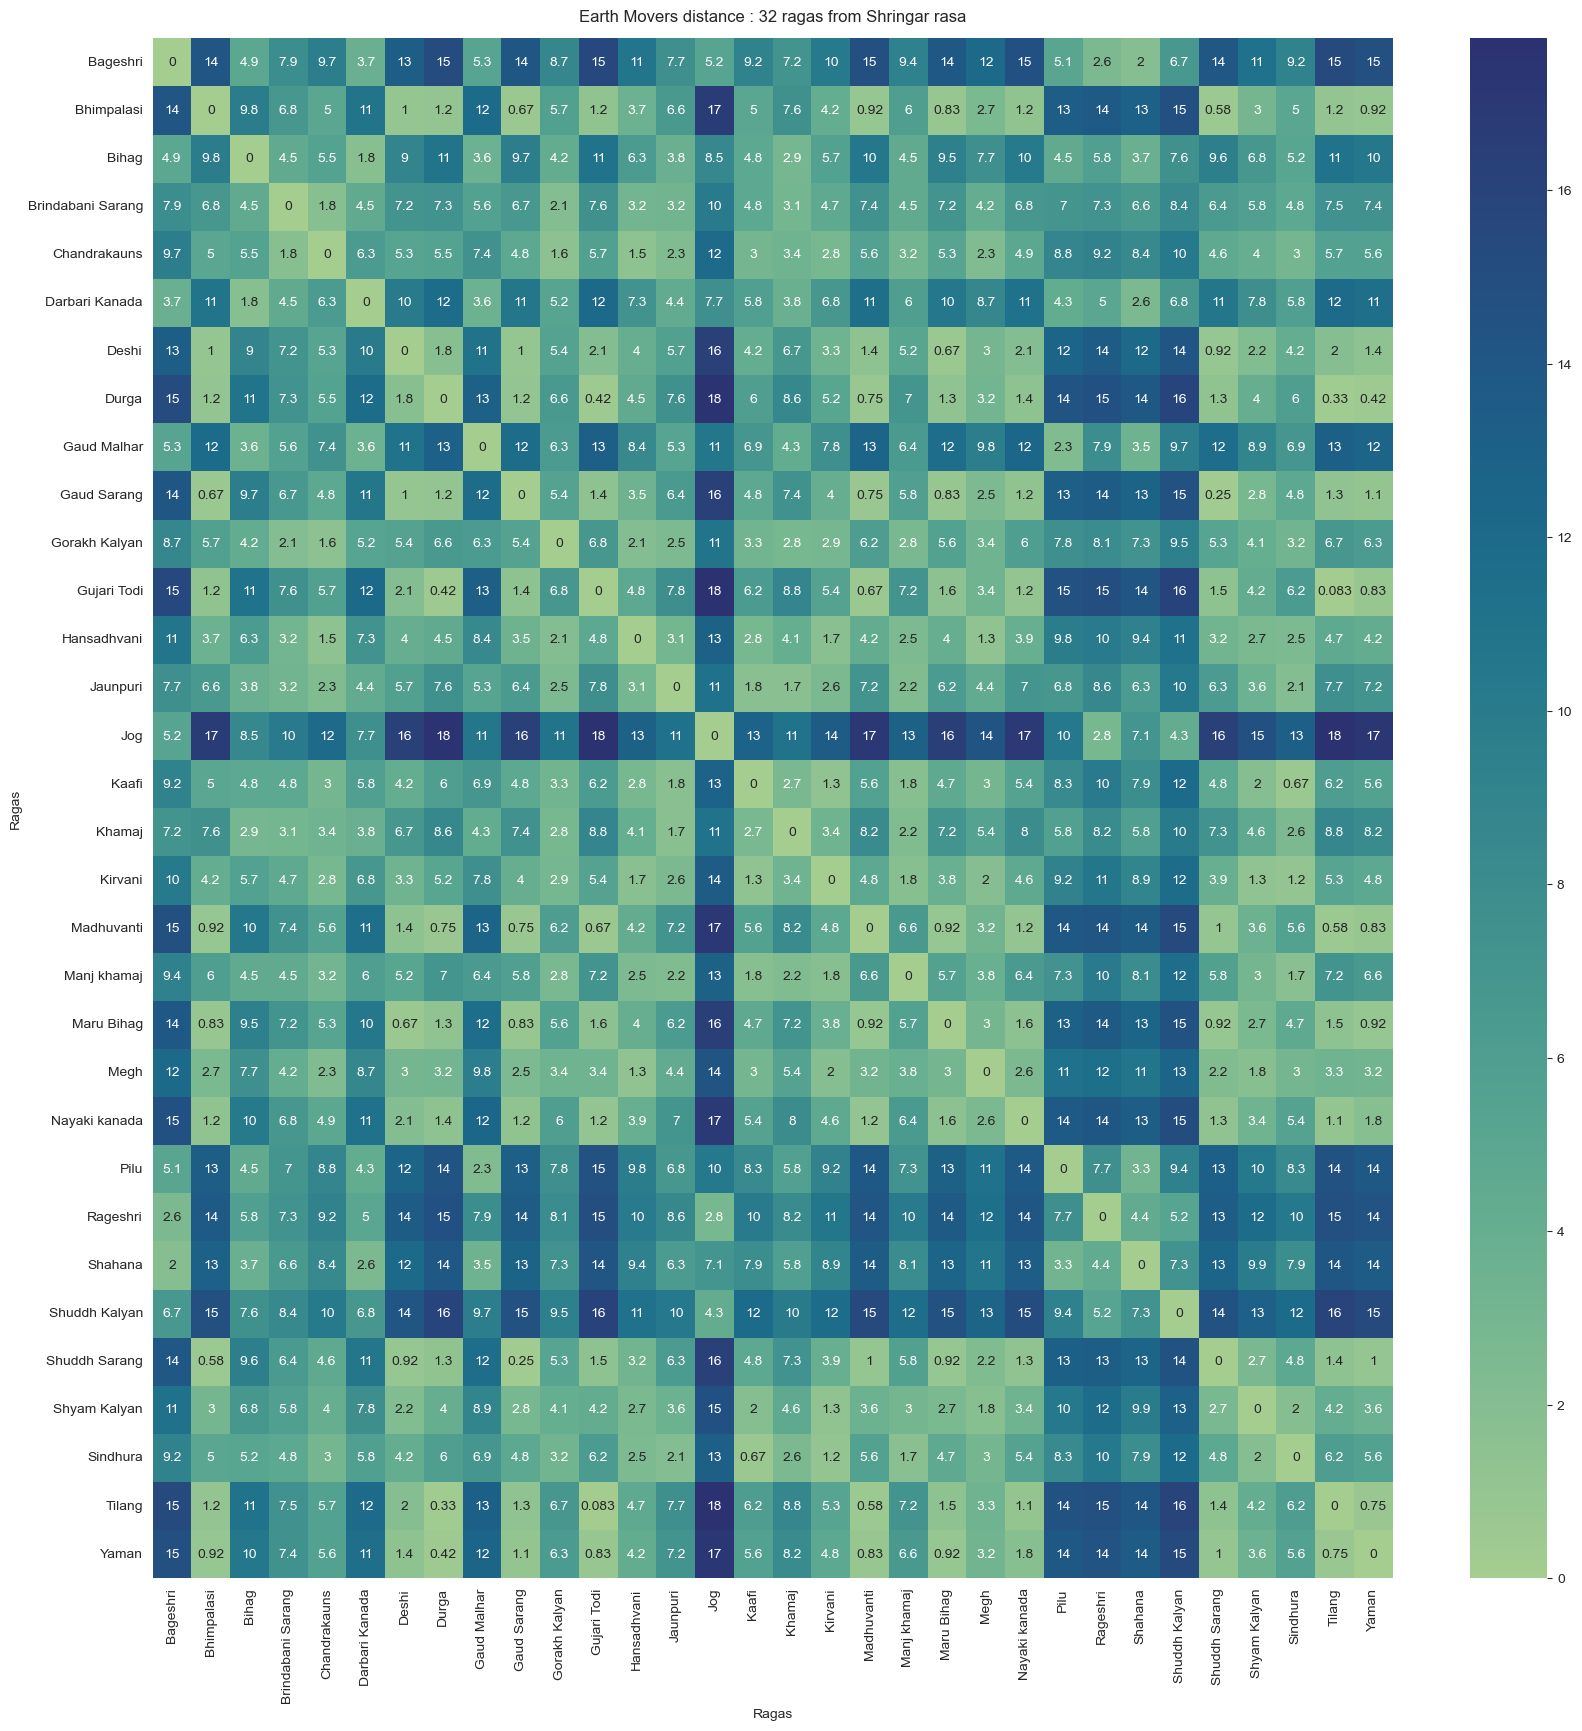

In [219]:
from scipy.stats import wasserstein_distance as wd
l = len(shringar_swara_distribution_per_raga)
dist=np.zeros((l,l))
for i in range(len(shringar_swara_distribution_per_raga)):
    p=shringar_swara_distribution_per_raga[i]
    for j in range(len(shringar_swara_distribution_per_raga)):
        q=shringar_swara_distribution_per_raga[j]
        dist[i][j] = wd(p,q)
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(dist, annot=True, vmin=np.min(dist), vmax=np.max(dist), 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);
title = 'Earth Movers distance : '+ str(len(raga_names)) +' ragas from Shringar rasa'

heatmap.set_title(title,
                  fontdict={'fontsize':12}, pad=12);

heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

In [160]:
len_5 =[]
len_6 =[]
len_7_and =[]
for idx in range(len(shringar_swara_distribution_per_raga)):
    dist = np.array(shringar_swara_distribution_per_raga[idx], dtype=int)
    if len(dist[dist!=0])==5:
        len_5.append(dist)
    if len(dist[dist!=0])==6:
        len_6.append(dist)
    if len(dist[dist!=0])>6:
        len_7_and.append(dist)

len_5

[array([21,  0, 28,  0,  0, 21,  0, 25,  0,  0,  0, 20]),
 array([18,  0,  0, 15,  0, 20,  0,  0, 19,  0,  0, 21]),
 array([5, 0, 6, 0, 0, 6, 0, 4, 0, 6, 0, 0]),
 array([5, 5, 0, 3, 0, 0, 4, 0, 7, 0, 0, 0]),
 array([13,  0, 17,  0,  0,  7,  0, 18,  0,  0, 10,  0]),
 array([12,  0, 12,  0,  0,  4,  0,  1,  0,  0,  5,  0]),
 array([3, 0, 0, 0, 7, 5, 0, 6, 0, 0, 0, 4])]

In [162]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))               


for i in range(len(len_5)):
    p=len_5[i]
    p = p[p!=0]
    for j in range(len(len_5)):
        q=len_5[j]
        q = q[q!=0]
        print(i, j, '%.3f bits' % kl(p, q))

0 0 0.000 bits
0 1 27.623 bits
0 2 169.471 bits
0 3 186.049 bits
0 4 69.189 bits
0 5 178.497 bits
0 6 177.684 bits
1 0 -17.303 bits
1 1 0.000 bits
1 2 116.793 bits
1 3 130.154 bits
1 4 41.585 bits
1 5 128.915 bits
1 6 128.133 bits
2 0 -38.489 bits
2 1 -32.875 bits
2 2 0.000 bits
2 3 4.328 bits
2 4 -21.032 bits
2 5 0.536 bits
2 6 3.534 bits
3 0 -36.306 bits
3 1 -31.512 bits
3 2 -1.912 bits
3 3 0.000 bits
3 4 -21.951 bits
3 5 -1.717 bits
3 6 1.635 bits
4 0 -35.252 bits
4 1 -17.844 bits
4 2 63.387 bits
4 3 69.797 bits
4 4 0.000 bits
4 5 69.837 bits
4 6 65.440 bits
5 0 -33.666 bits
5 1 -24.101 bits
5 2 14.904 bits
5 3 19.093 bits
5 4 -13.735 bits
5 5 0.000 bits
5 6 21.535 bits
6 0 -37.718 bits
6 1 -31.191 bits
6 2 -0.554 bits
6 3 3.571 bits
6 4 -22.549 bits
6 5 3.042 bits
6 6 0.000 bits


# Bhakti

In [ ]:
[20, 0, 0, 40, 22] = [20,40,22]
[10, 0, 3, 0, 30] = [10,3,30]
 


,Raga,FileName,Rasa
0,Ahir Bhairav,Ahir_bhairav_D1T3.txt,Bhakti
1,Asavari,Asavari_D1T5.txt,Bhakti
2,Bhairavi,Bhairavi_D1T10.txt,Bhakti
3,Bhatiyar,Bhatiyar_D1T11.txt,Bhakti
4,Bhupal Todi,Bhupal_todi_D1T13.txt,Bhakti
5,Bhupali,Bhupali_D1T14.txt,Bhakti
6,Bibhas,Bibhas_D1T15.txt,Bhakti
7,Chayanat,Chayanat_D2T2.txt,Bhakti
8,Gunakri,Gunakri_D2T12.txt,Bhakti
9,Jogiya,Jogiya_D3T2.txt,Bhakti


Text(158.22222222222223, 0.5, 'Ragas')

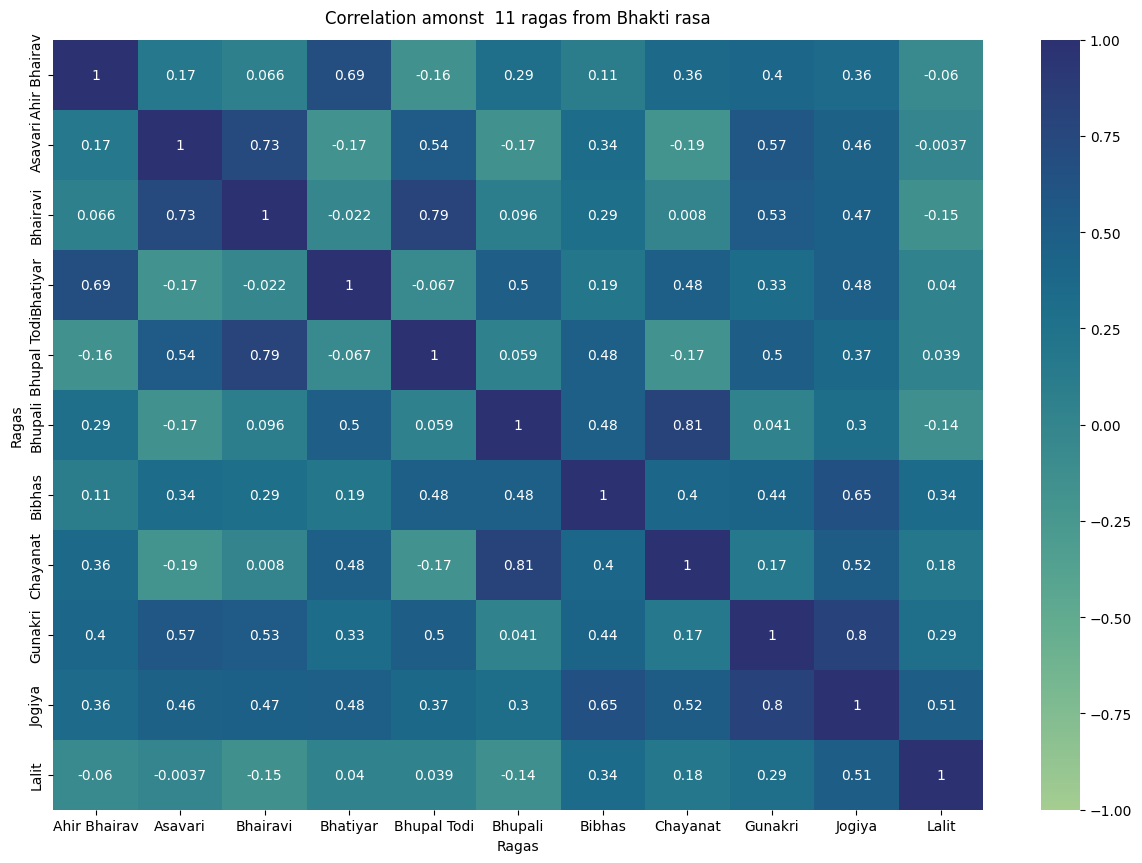

In [73]:
#bhakti or devotion

bhakti = raga_rasa[raga_rasa['Rasa'] == 'Bhakti'].reset_index()[['Raga', 'FileName', 'Rasa']]
display(bhakti)
bhakti_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(bhakti)
R1 = np.corrcoef(bhakti_swara_distribution_per_raga)
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(R1, annot=True, vmin=-1, vmax=1, 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);
title = 'Correlation amonst  '+ str(len(raga_names)) +' ragas from Bhakti rasa'
heatmap.set_title(title,
                  fontdict={'fontsize':12}, pad=12);

heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

# Karuna

,Raga,FileName,Rasa
0,Bilaskhani Todi,Bilaskhani_todi_D1T17.txt,Karuna
1,Jaijavanti,Jaijaivanti_D2T16.txt,Karuna
2,Marva,Marva_D3T13.txt,Karuna
3,Miyan ki Todi,Miyan_ki_todi_D3T16.txt,Karuna
4,Purvi,purvi.txt,Karuna
5,Ramkali,ramkali.txt,Karuna
6,Sohini,sohini.txt,Karuna


Text(158.22222222222223, 0.5, 'Ragas')

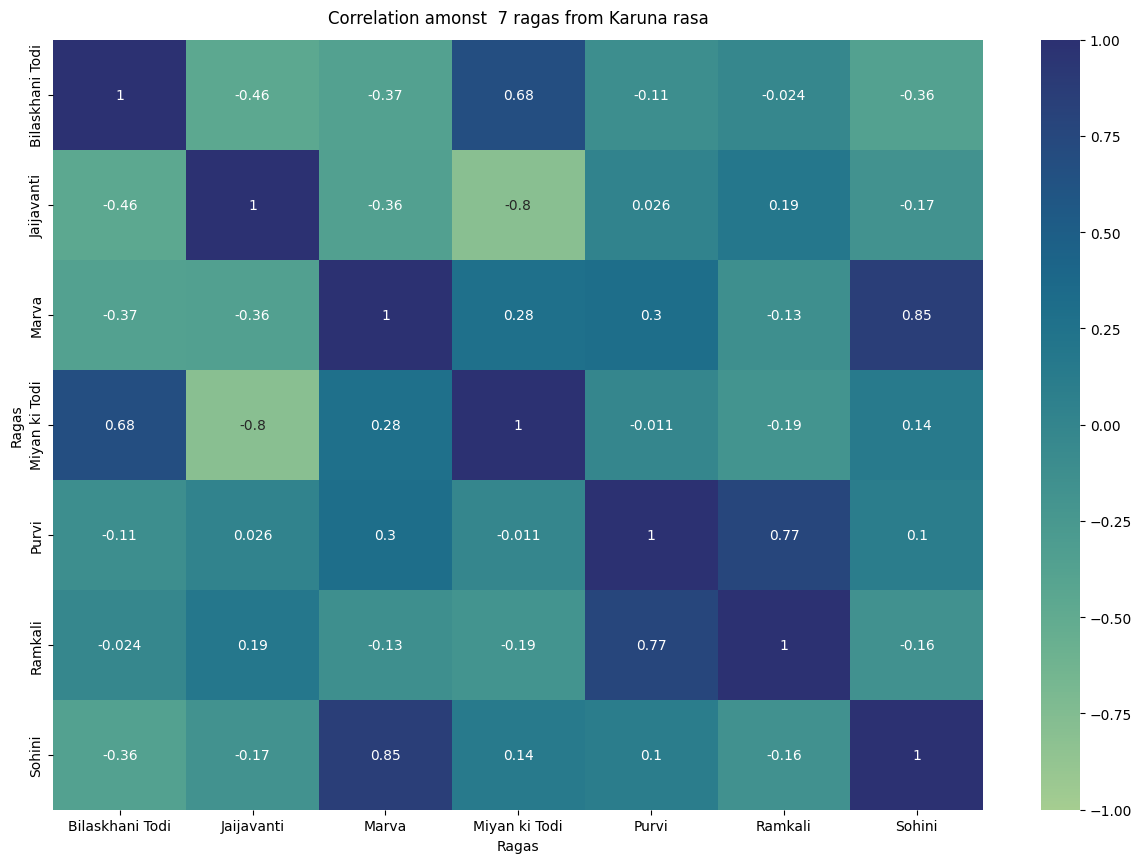

In [74]:
# Karuna or sadness


karuna = raga_rasa[raga_rasa['Rasa'] == 'Karuna'].reset_index()[['Raga', 'FileName', 'Rasa']]
display(karuna)
karuna_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(karuna)
R1 = np.corrcoef(karuna_swara_distribution_per_raga)
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(R1, annot=True, vmin=-1, vmax=1, 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);

title = 'Correlation amonst  '+ str(len(raga_names)) +' ragas from Karuna rasa'
heatmap.set_title(title,
                  fontdict={'fontsize':12}, pad=12);

heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

,Raga,FileName,Rasa
0,Bilaskhani Todi,Bilaskhani_todi_D1T17.txt,Karuna
1,Jaijavanti,Jaijaivanti_D2T16.txt,Karuna
2,Marva,Marva_D3T13.txt,Karuna
3,Miyan ki Todi,Miyan_ki_todi_D3T16.txt,Karuna
4,Purvi,purvi.txt,Karuna
5,Ramkali,ramkali.txt,Karuna
6,Sohini,sohini.txt,Karuna


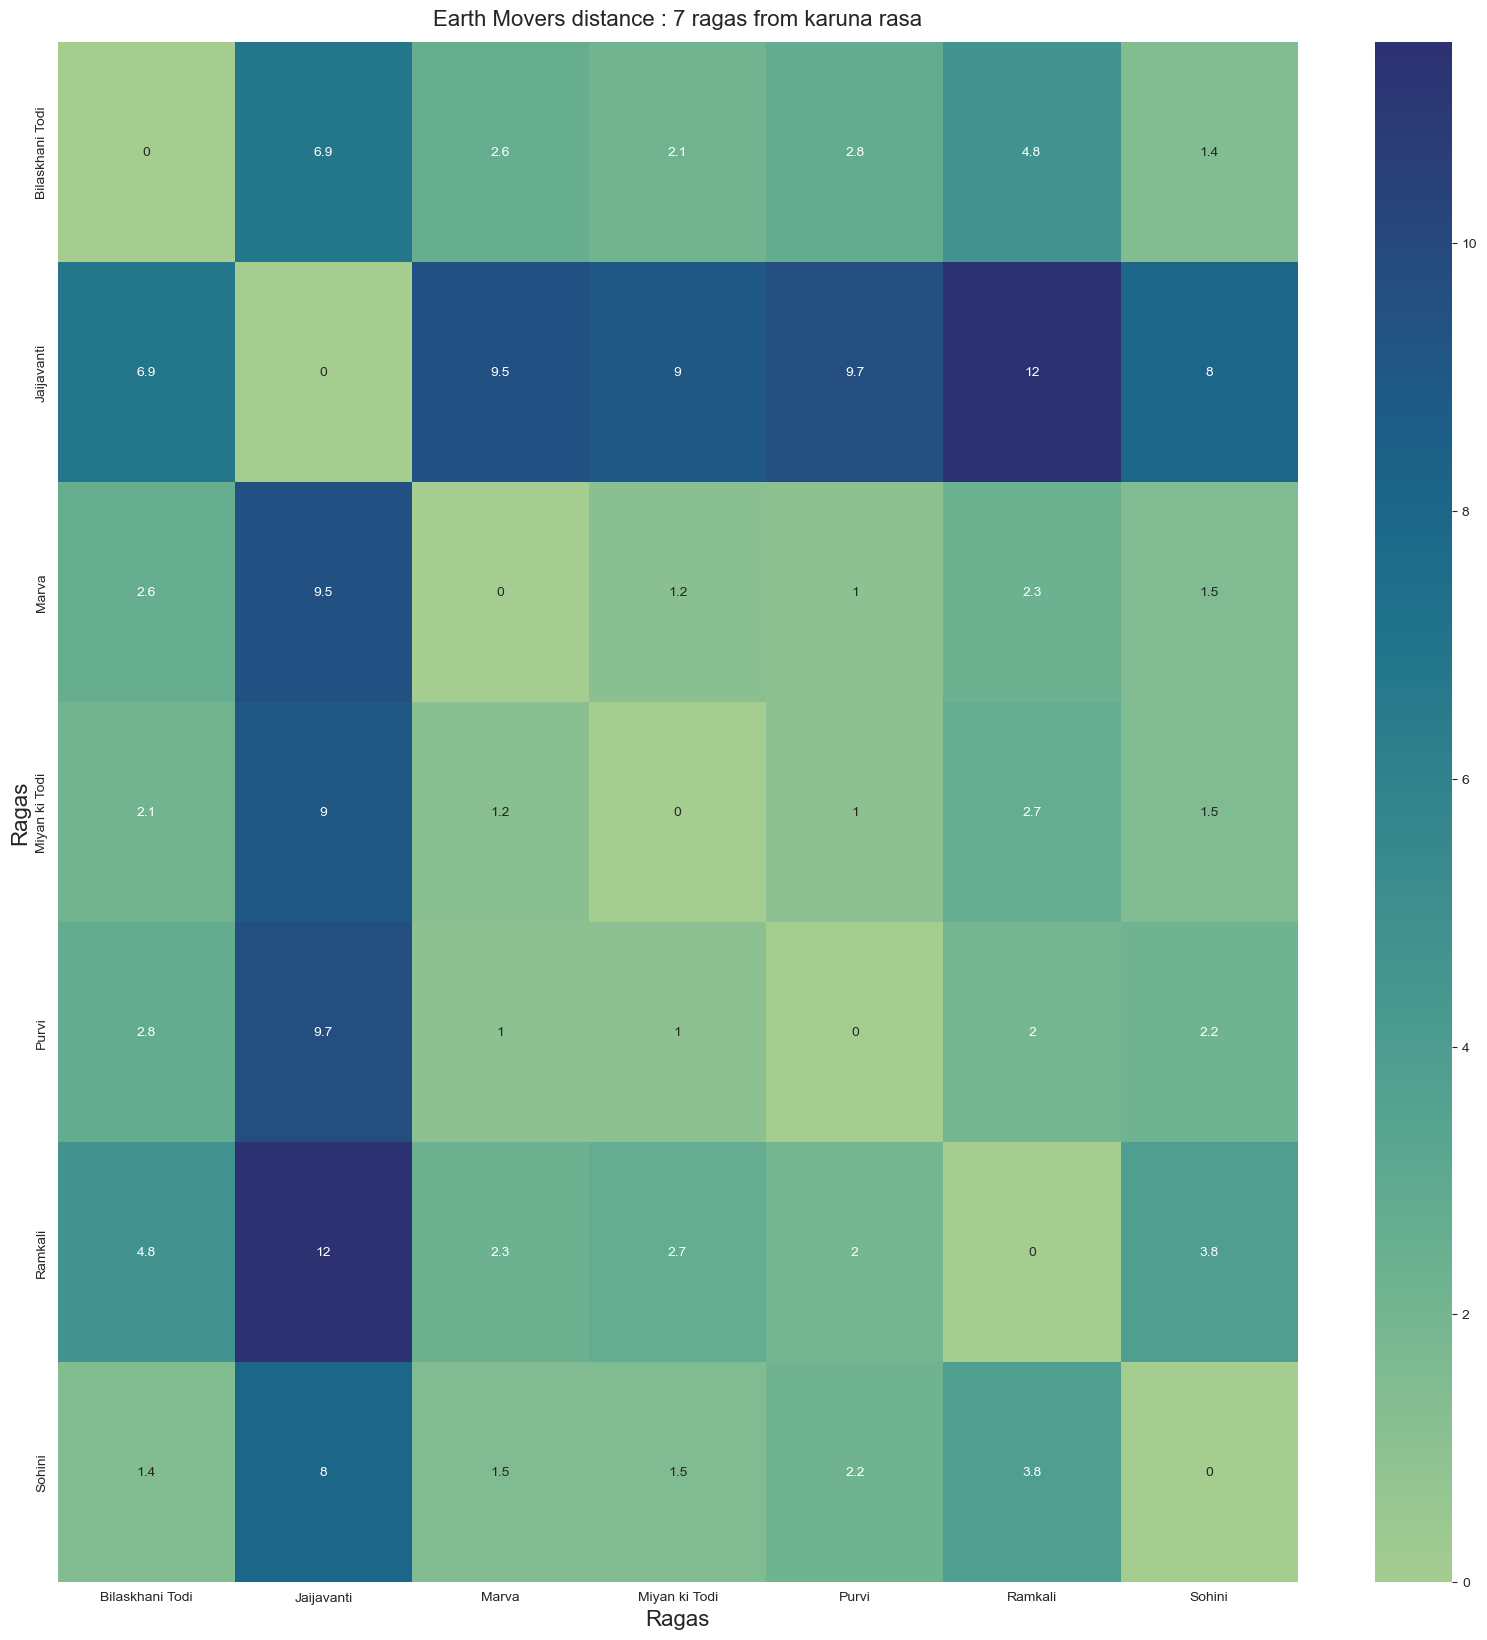

In [232]:
karuna = raga_rasa[raga_rasa['Rasa'] == 'Karuna'].reset_index()[['Raga', 'FileName', 'Rasa']]

func(karuna, 'karuna')

# Veer

,Raga,FileName,Rasa
0,Adana,Adana_D1T2.txt,Veer
1,Hamir,Hamir_D2T13.txt,Veer
2,Hindol,Hindol_D2T15.txt,Veer
3,Kamod,Kamod_D3T4.txt,Veer
4,Kedar,Kedar_D3T5.txt,Veer


Text(160.22222222222223, 0.5, 'Ragas')

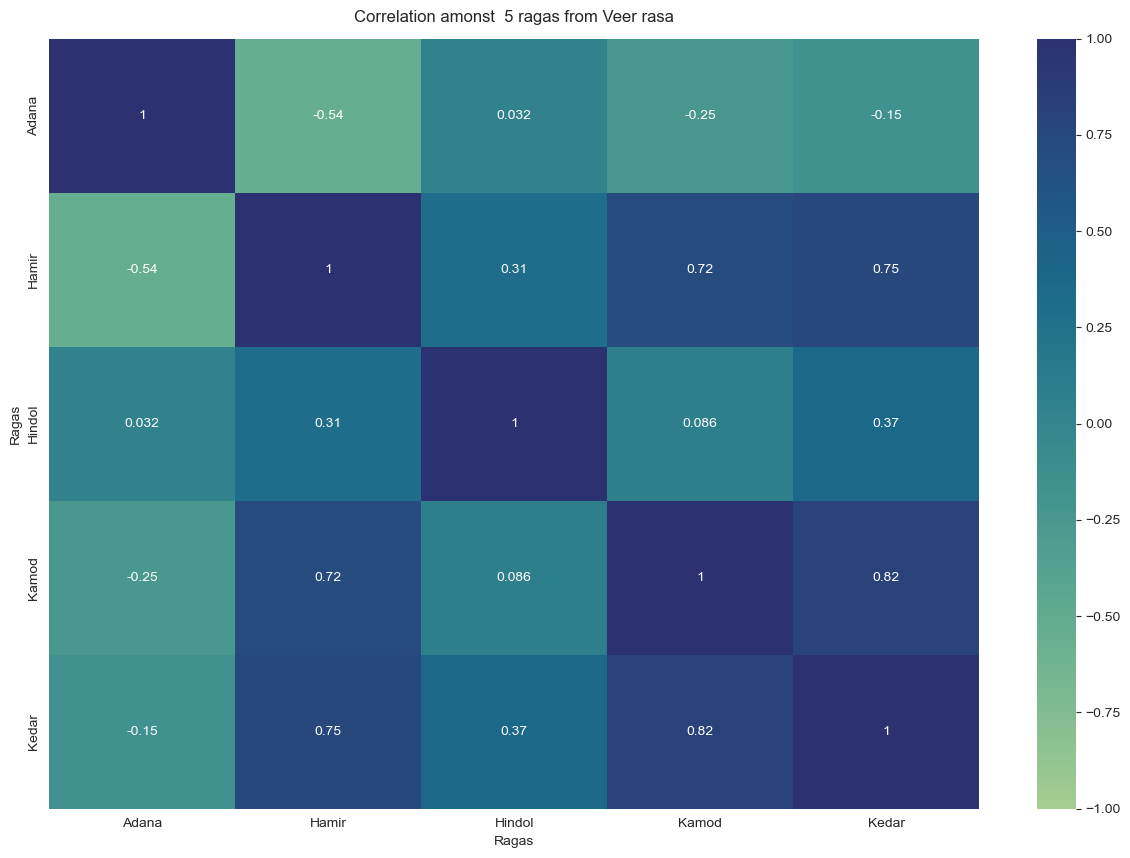

In [233]:
#Veer or bravery

veer = raga_rasa[raga_rasa['Rasa'] == 'Veer'].reset_index()[['Raga', 'FileName', 'Rasa']]
display(veer)
veer_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(veer)
R1 = np.corrcoef(veer_swara_distribution_per_raga)
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(R1, annot=True, vmin=-1, vmax=1, 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);

title = 'Correlation amonst  '+ str(len(raga_names)) +' ragas from Veer rasa'
heatmap.set_title(title,
                  fontdict={'fontsize':12}, pad=12);


heatmap.set_xlabel('Ragas')
heatmap.set_ylabel('Ragas')

,Raga,FileName,Rasa
0,Adana,Adana_D1T2.txt,Veer
1,Hamir,Hamir_D2T13.txt,Veer
2,Hindol,Hindol_D2T15.txt,Veer
3,Kamod,Kamod_D3T4.txt,Veer
4,Kedar,Kedar_D3T5.txt,Veer


Text(222.72222222222223, 0.5, 'Ragas')

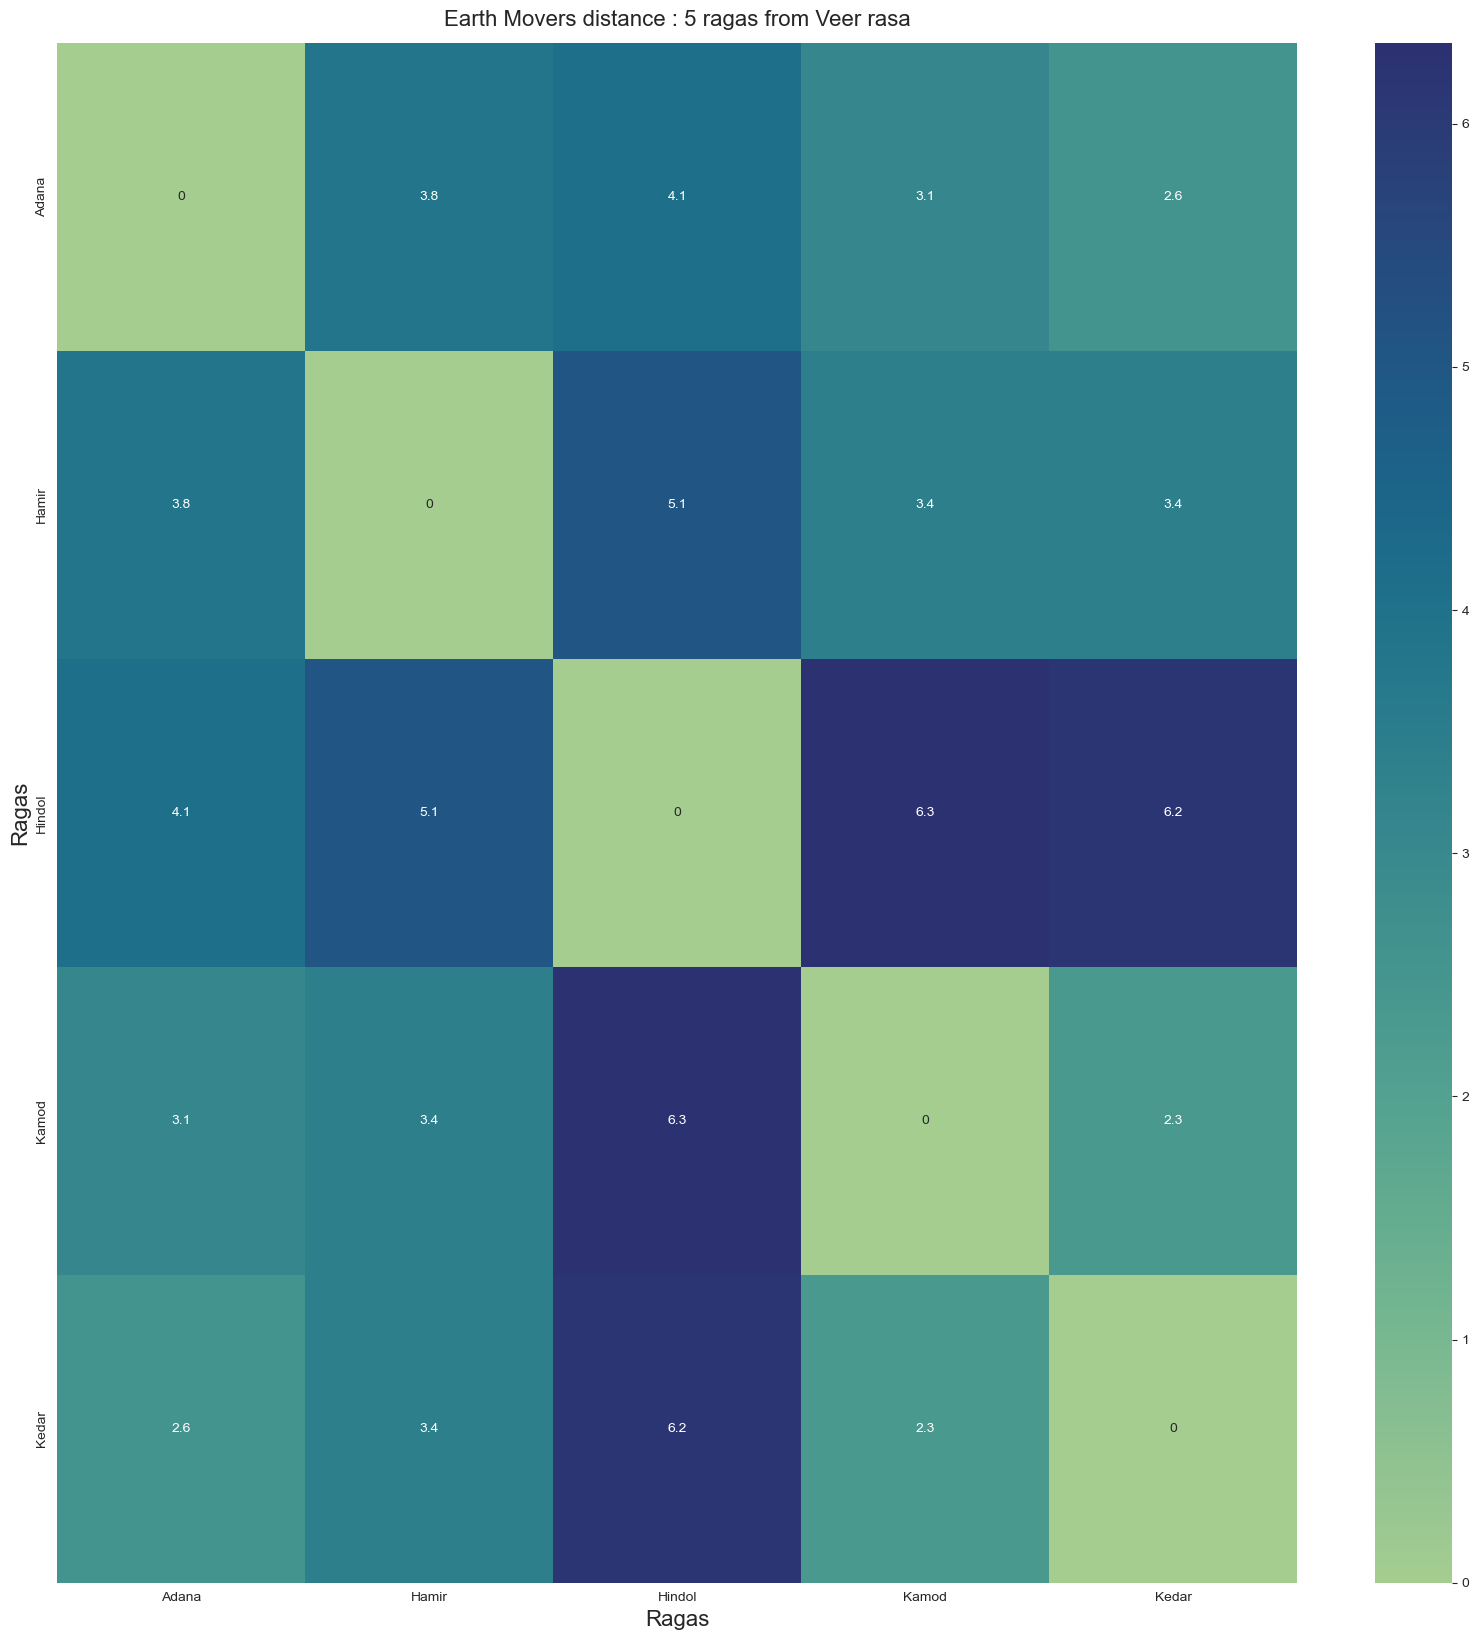

In [226]:
from scipy.stats import wasserstein_distance as wd
veer = raga_rasa[raga_rasa['Rasa'] == 'Veer'].reset_index()[['Raga', 'FileName', 'Rasa']]
display(veer)
veer_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(veer)

l = len(veer_swara_distribution_per_raga)
dist=np.zeros((l,l))
for i in range(len(veer_swara_distribution_per_raga)):
    p=veer_swara_distribution_per_raga[i]
    for j in range(len(veer_swara_distribution_per_raga)):
        q=veer_swara_distribution_per_raga[j]
        dist[i][j] = wd(p,q)
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(dist, annot=True, vmin=np.min(dist), vmax=np.max(dist), 
                      cmap="crest", 
                      xticklabels = raga_names,
                      yticklabels = raga_names);
title = 'Earth Movers distance : '+ str(len(raga_names)) +' ragas from Veer rasa'

heatmap.set_title(title,
                  fontdict={'fontsize':16}, pad=12);

heatmap.set_xlabel('Ragas', fontsize=16)
heatmap.set_ylabel('Ragas', fontsize=16)

## Earth Movers Distance

In [109]:
from scipy.stats import wasserstein_distance as wd

def func(rasa_df, rasa_name, n=1):
    print(rasa_name)
    if n == 1:
        rasa_swara_distribution_per_raga, raga_names = get_swara_distribution_per_raga(rasa_df)
    else:
        rasa_swara_distribution_per_raga, raga_names = get_n_grams_per_raga(rasa_df, n)
    l = len(rasa_swara_distribution_per_raga)
    dist=np.zeros((l,l))
   
    for i in range(len(rasa_swara_distribution_per_raga)):
        p=rasa_swara_distribution_per_raga[i]
        for j in range(len(rasa_swara_distribution_per_raga)):
            q=rasa_swara_distribution_per_raga[j]
            dist[i][j] = wd(p,q)
    
    
    plt.figure(figsize=(20, 20))
    heatmap = sns.heatmap(dist, annot=True, vmin=np.min(dist), vmax=np.max(dist), 
                          cmap="crest", 
                          xticklabels = raga_names,
                          yticklabels = raga_names);
    title = 'Earth Movers distance ({}-grams) : '.format(n) + str(len(raga_names)) +' ragas from '+rasa_name+' rasa'

    heatmap.set_title(title,
                      fontdict={'fontsize':16}, pad=12);

    heatmap.set_xlabel('Ragas', fontsize=16)
    heatmap.set_ylabel('Ragas', fontsize=16)
    return dist



## Combining Virah, Karuna and Shaant, Bhakti

In [64]:
virah = raga_rasa[raga_rasa['Rasa'] == 'Virah'].reset_index()[['Raga', 'FileName', 'Rasa']]
karuna = raga_rasa[raga_rasa['Rasa'] == 'Karuna'].reset_index()[['Raga', 'FileName', 'Rasa']]
karuna2 = pd.concat([virah, karuna]).reset_index()[['Raga', 'FileName', 'Rasa']]

karuna2

shaant = raga_rasa[raga_rasa['Rasa'] == 'Shaant'].reset_index()[['Raga', 'FileName', 'Rasa']]
bhakti = raga_rasa[raga_rasa['Rasa'] == 'Bhakti'].reset_index()[['Raga', 'FileName', 'Rasa']]
bhakti2 = pd.concat([shaant, bhakti]).reset_index()[['Raga', 'FileName', 'Rasa']]


In [65]:
veer = raga_rasa[raga_rasa['Rasa'] == 'Veer'].reset_index()[['Raga', 'FileName', 'Rasa']]
shringar = raga_rasa[raga_rasa['Rasa'] == 'Shringar'].reset_index().drop(index=14).reset_index()[['Raga', 'FileName', 'Rasa']]
adbhut = raga_rasa[raga_rasa['Rasa'] == 'Adbhut'].reset_index()[['Raga', 'FileName', 'Rasa']]
bhakti = raga_rasa[raga_rasa['Rasa'] == 'Bhakti'].reset_index()[['Raga', 'FileName', 'Rasa']]
karuna = raga_rasa[raga_rasa['Rasa'] == 'Karuna'].reset_index()[['Raga', 'FileName', 'Rasa']]

Veer (Bravery)
Veer (Bravery)
Veer (Bravery)
Shringar (Love)
Shringar (Love)
Shringar (Love)
Adbhut (Wonderment)
Adbhut (Wonderment)
Adbhut (Wonderment)
Bhakti (Devotion)
Bhakti (Devotion)
Bhakti (Devotion)
Karuna (Gloomy)
Karuna (Gloomy)
Karuna (Gloomy)


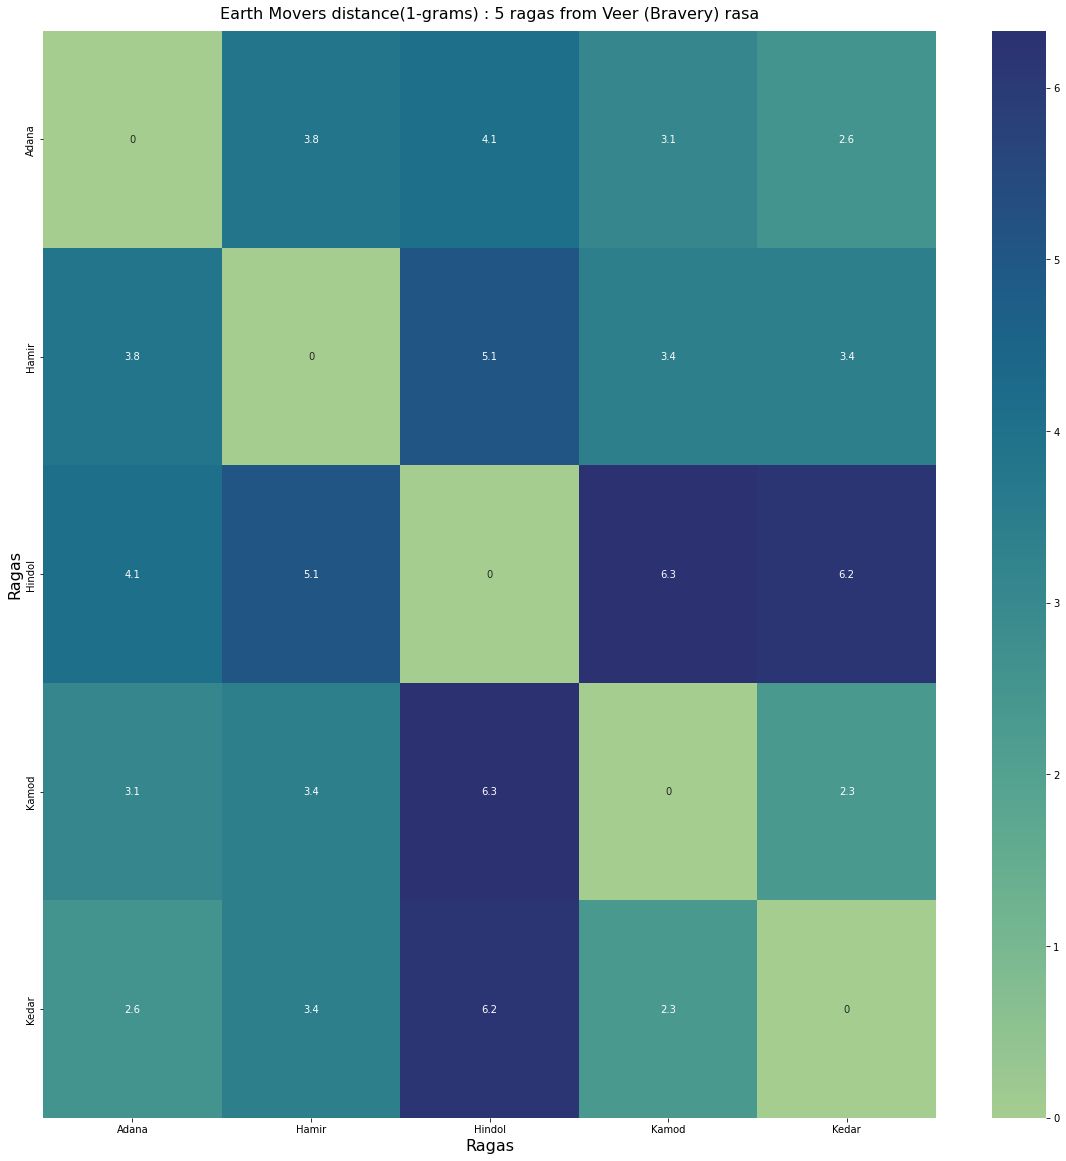

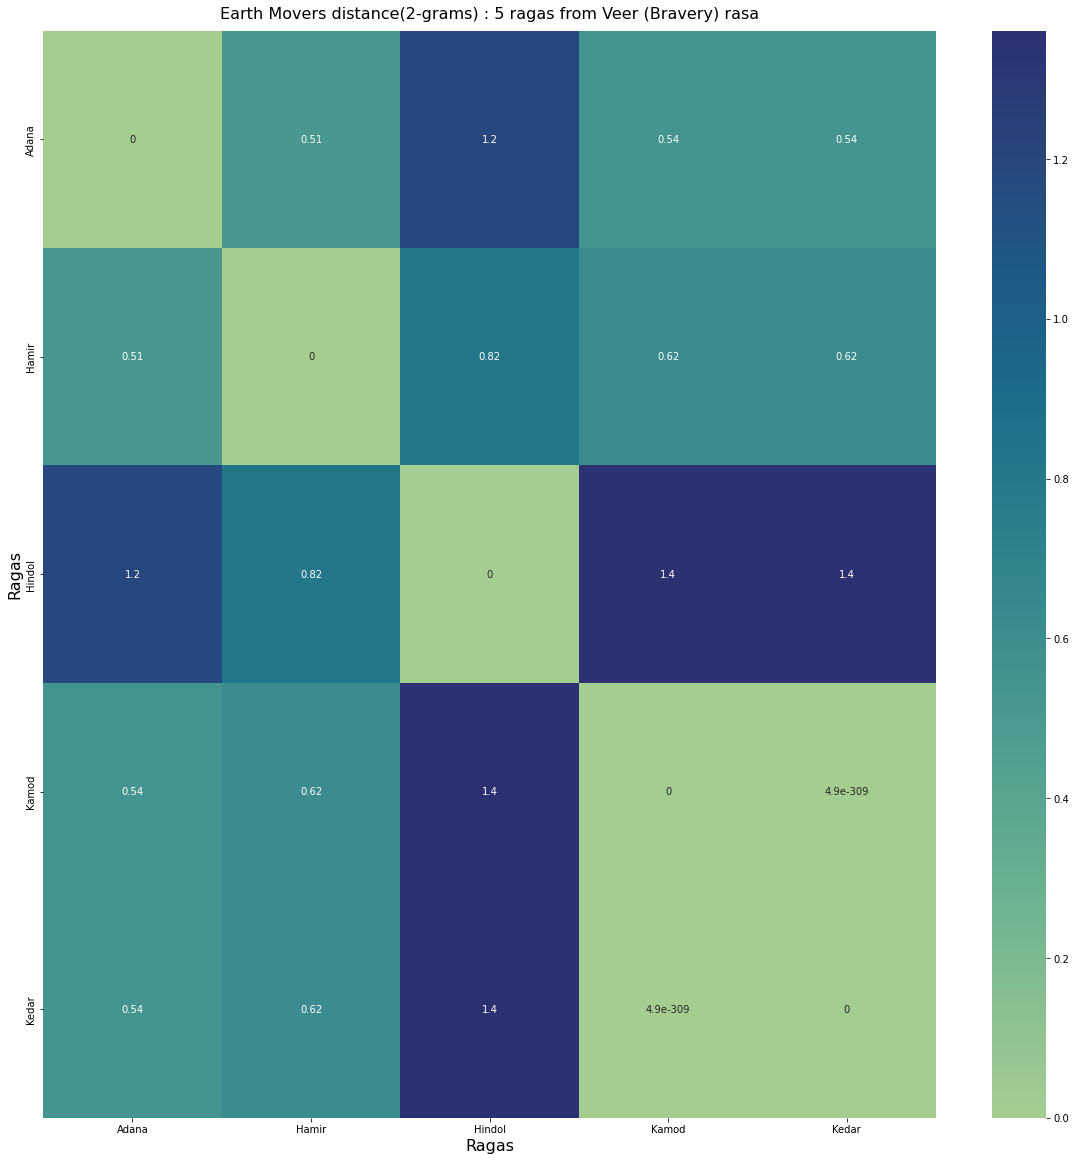

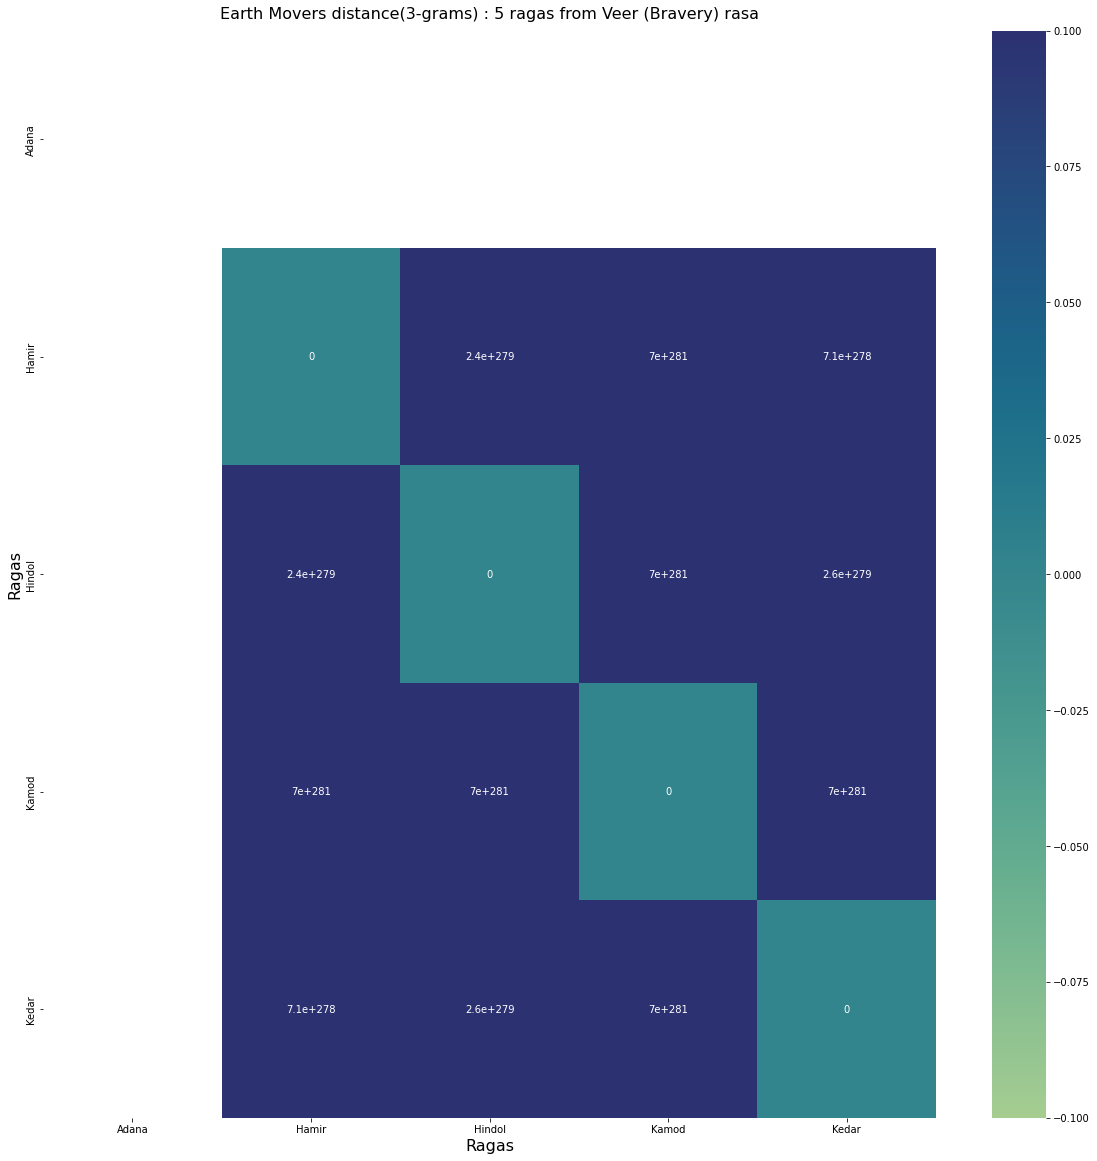

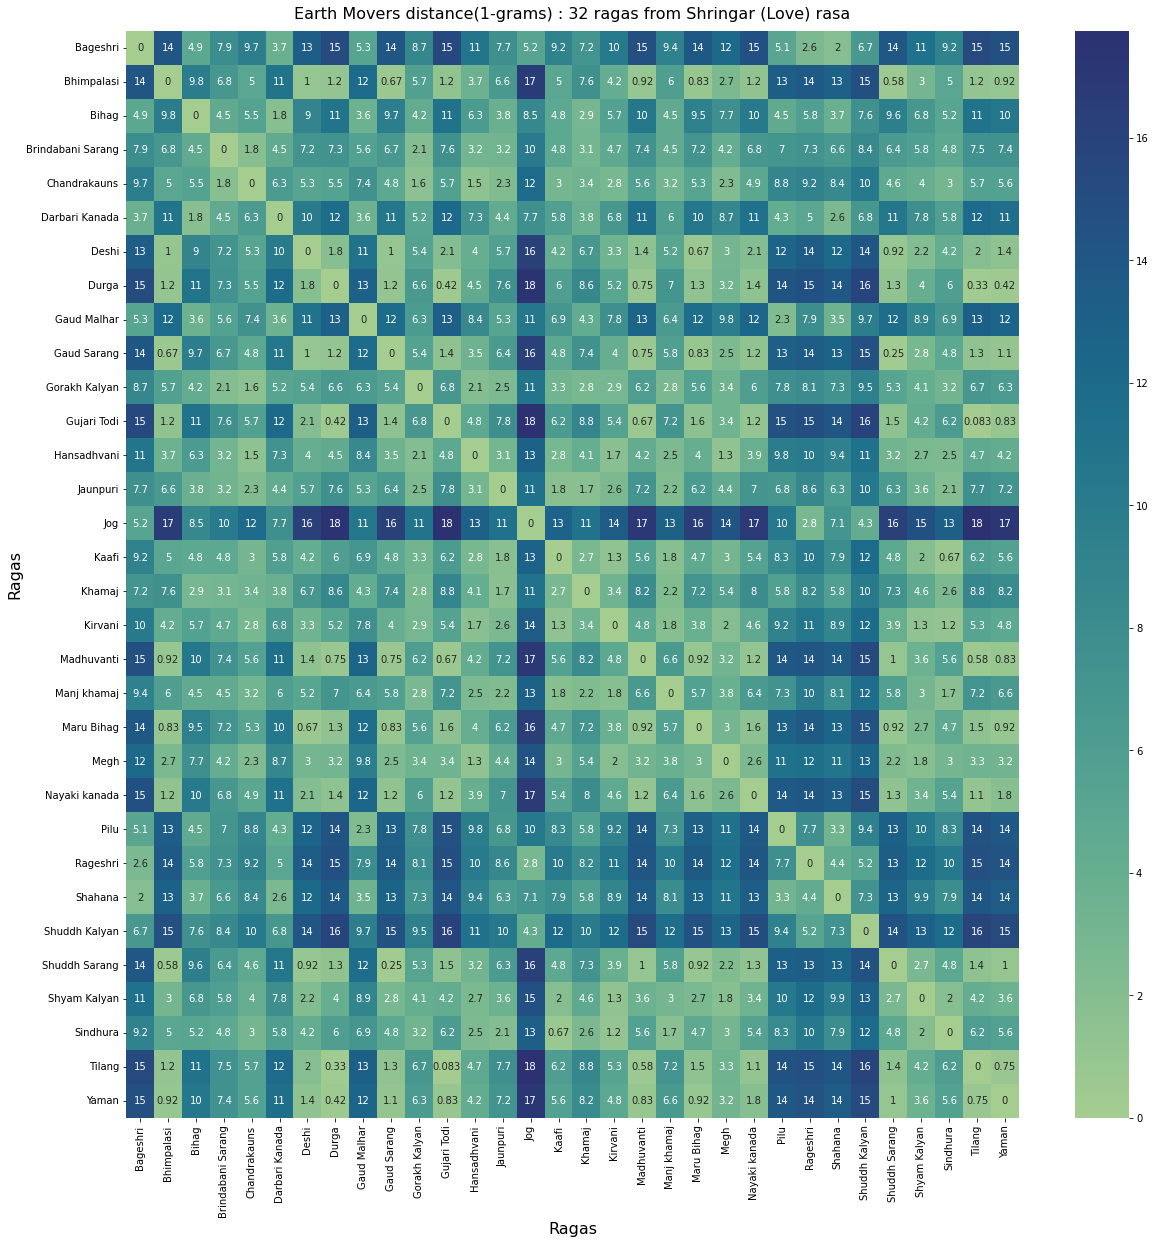

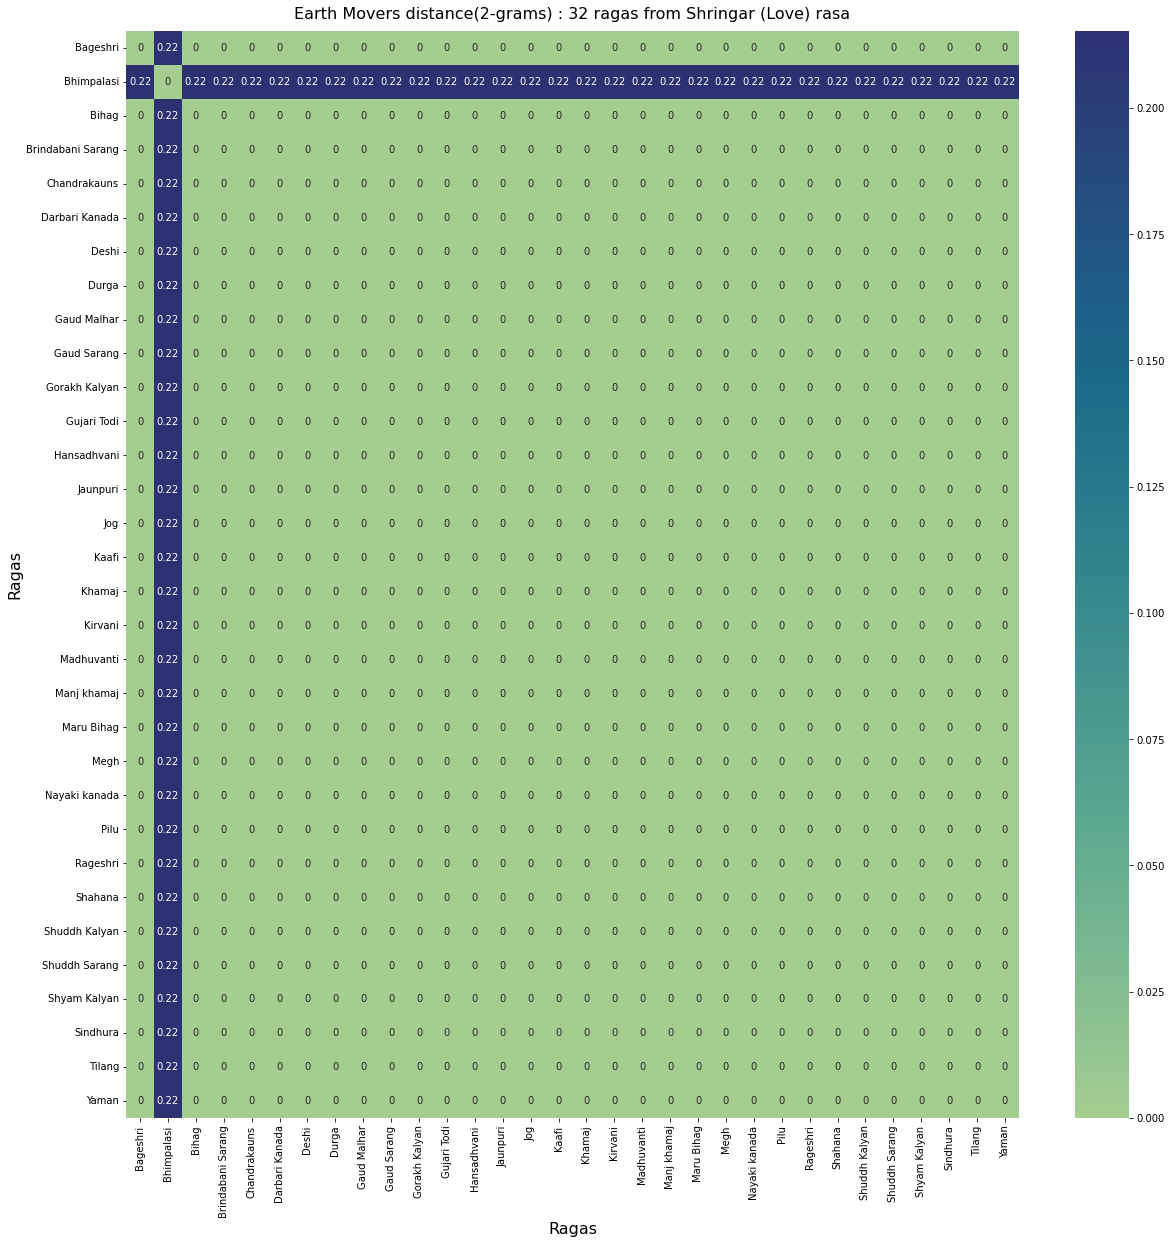

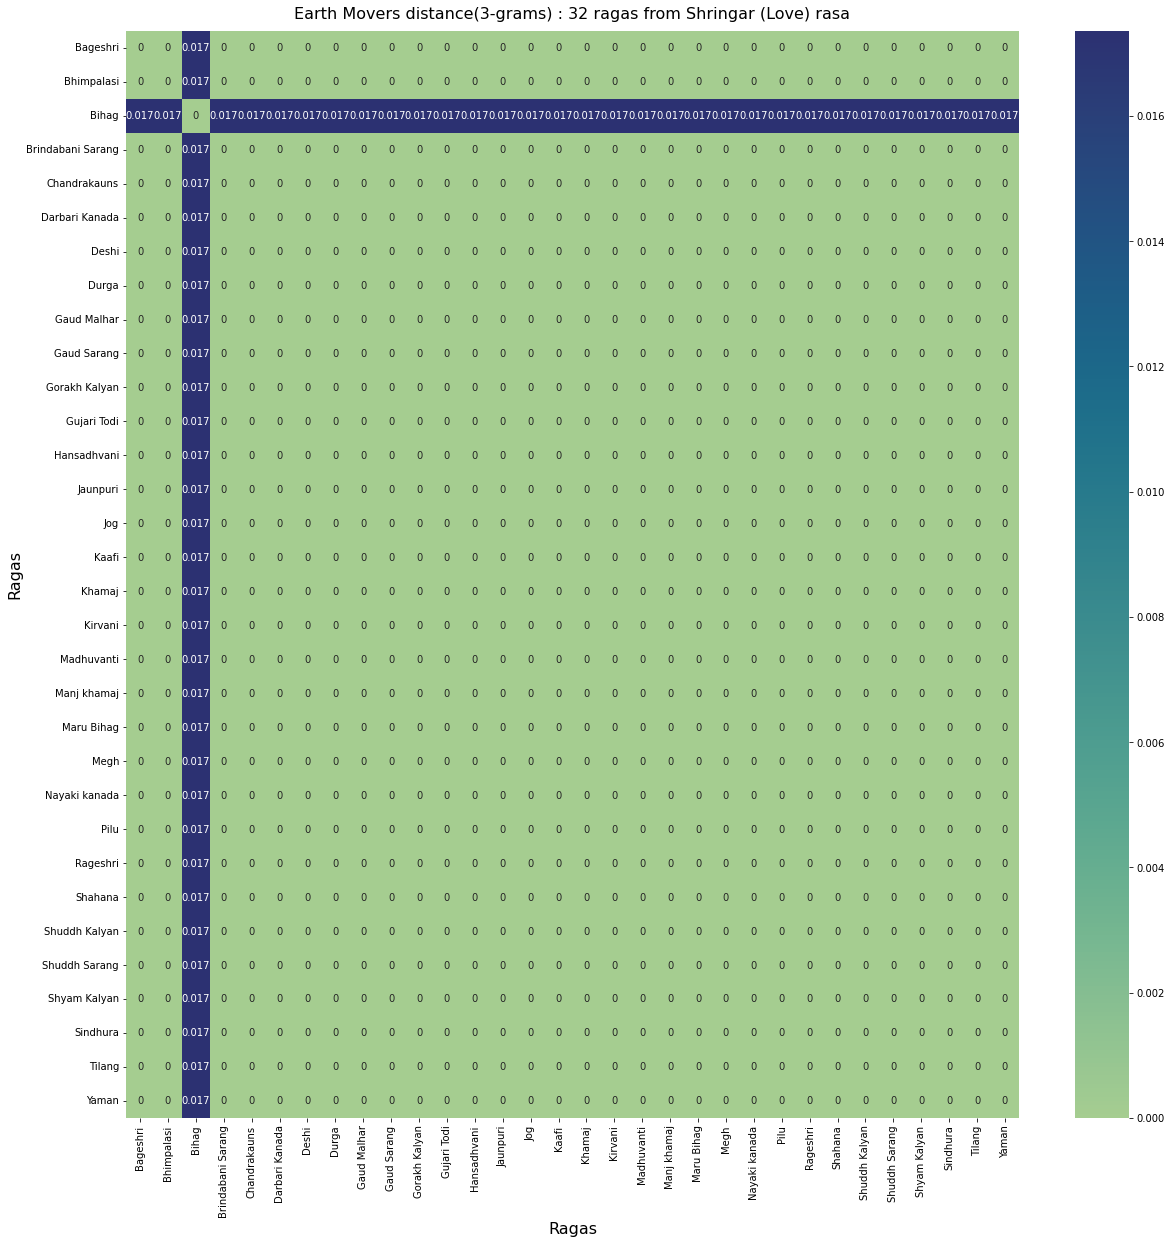

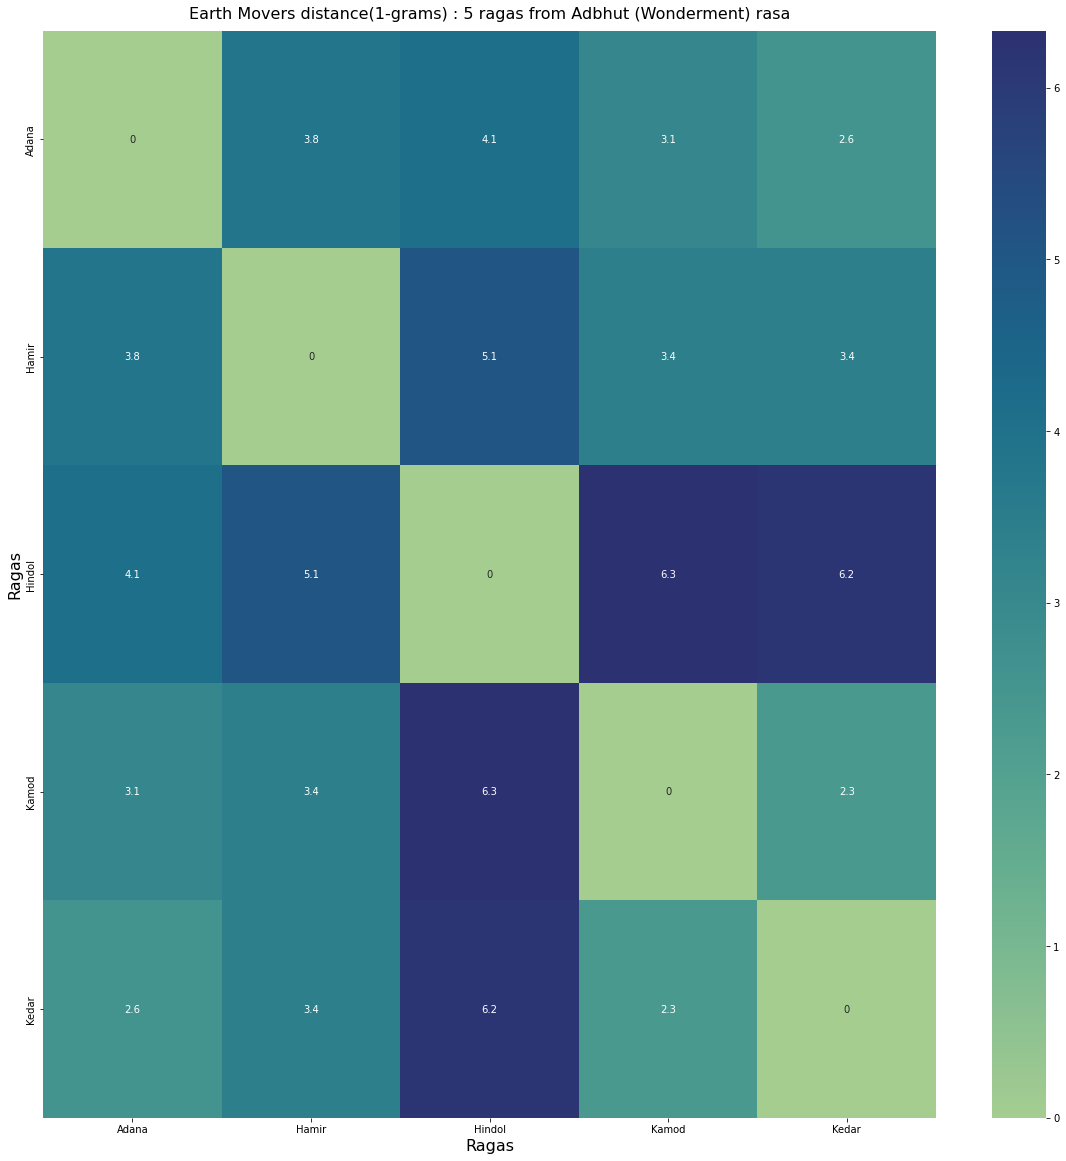

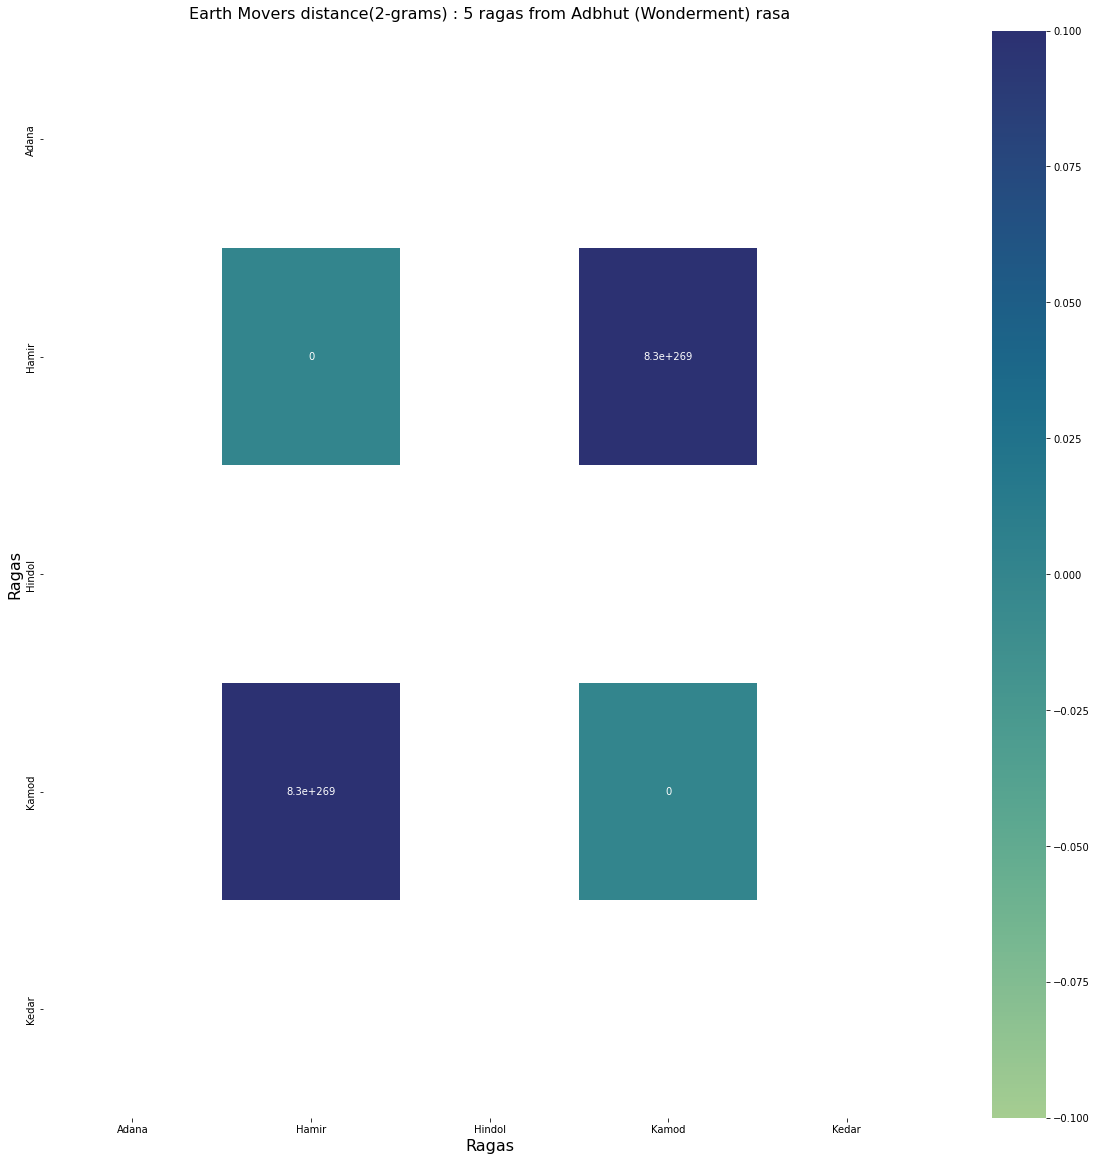

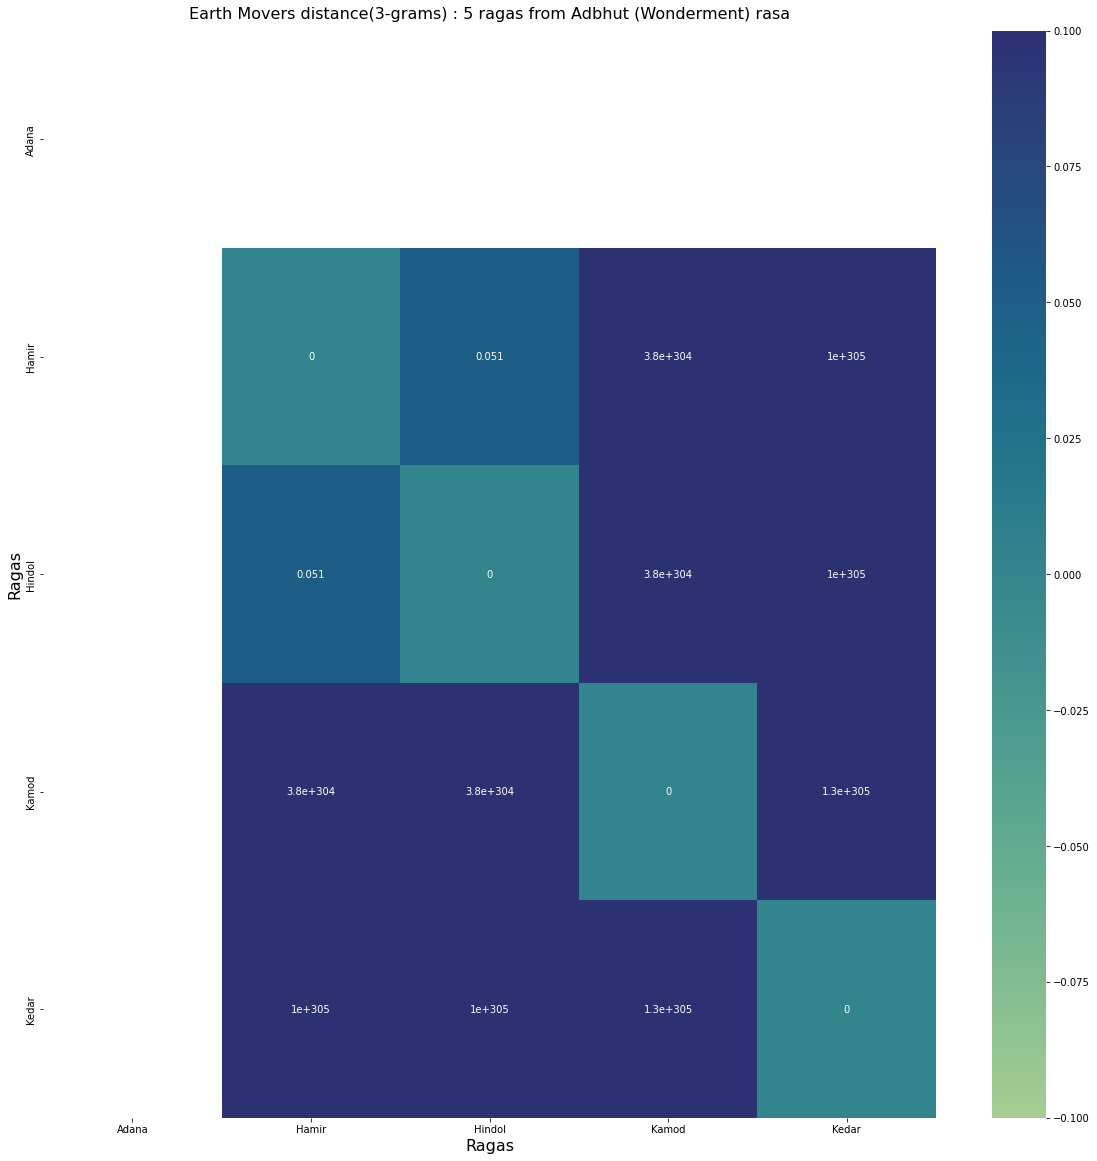

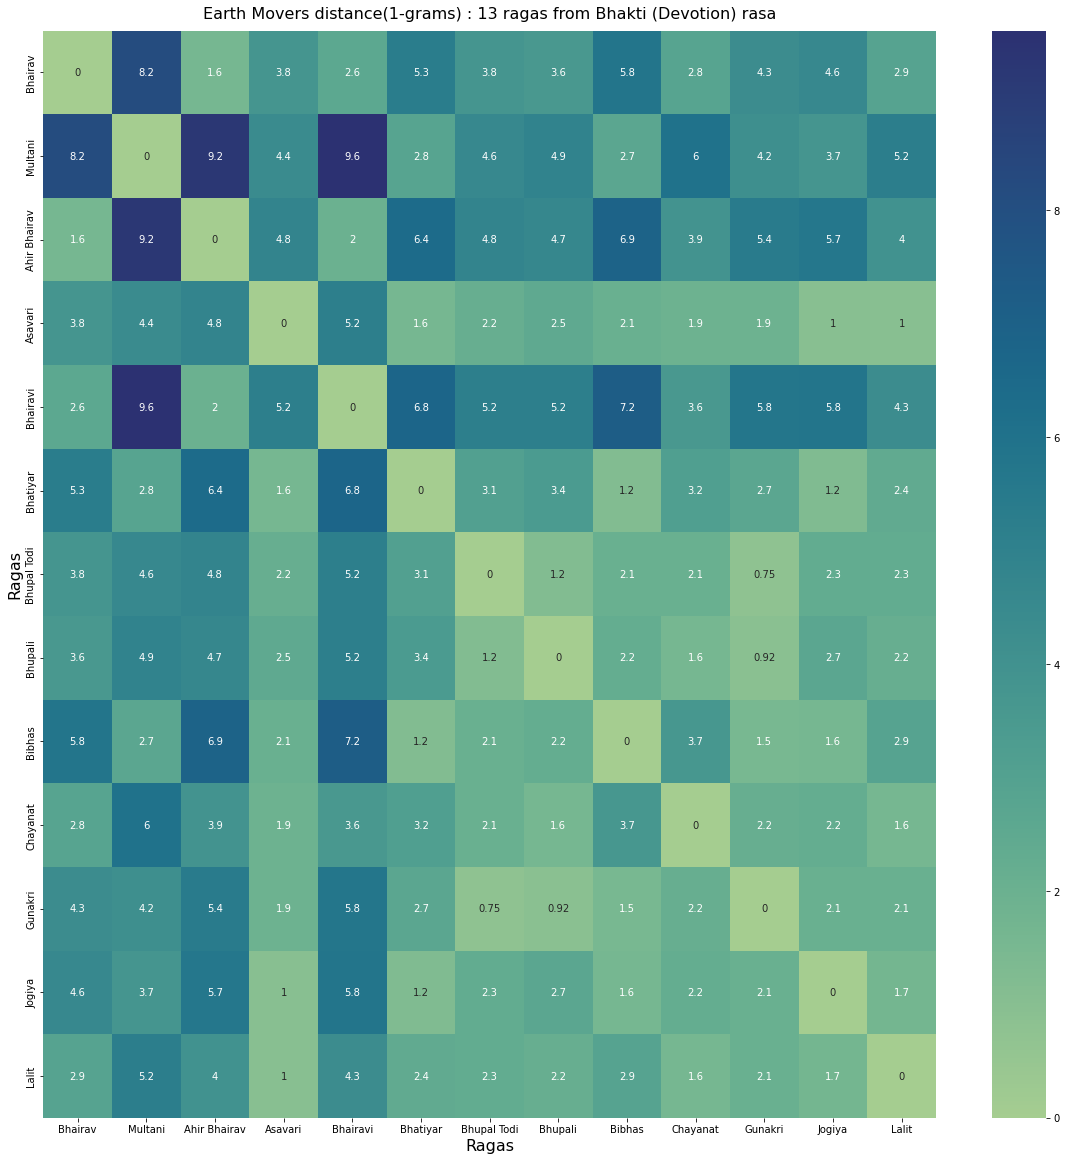

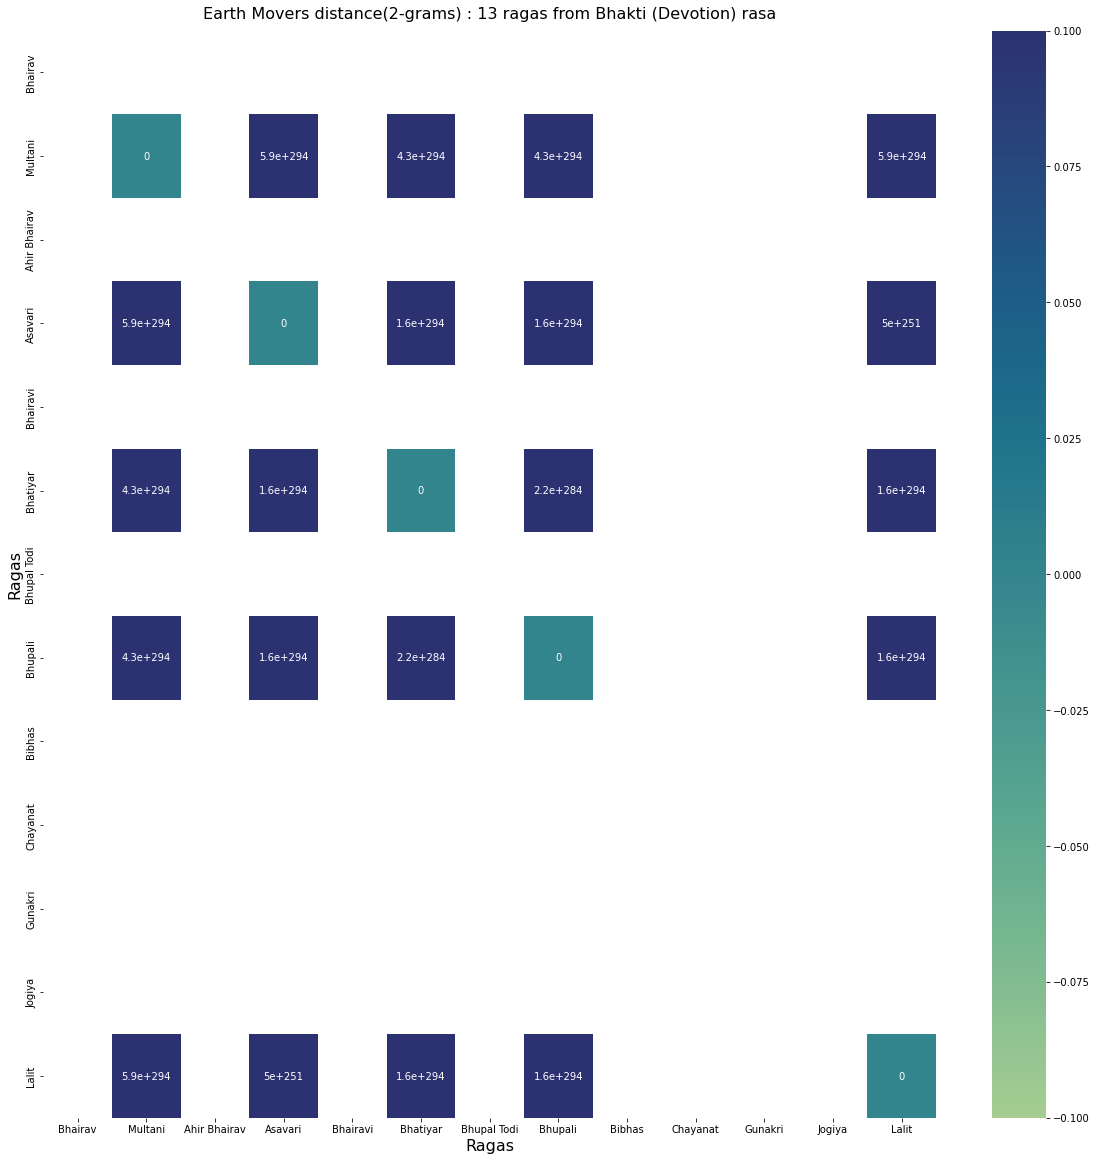

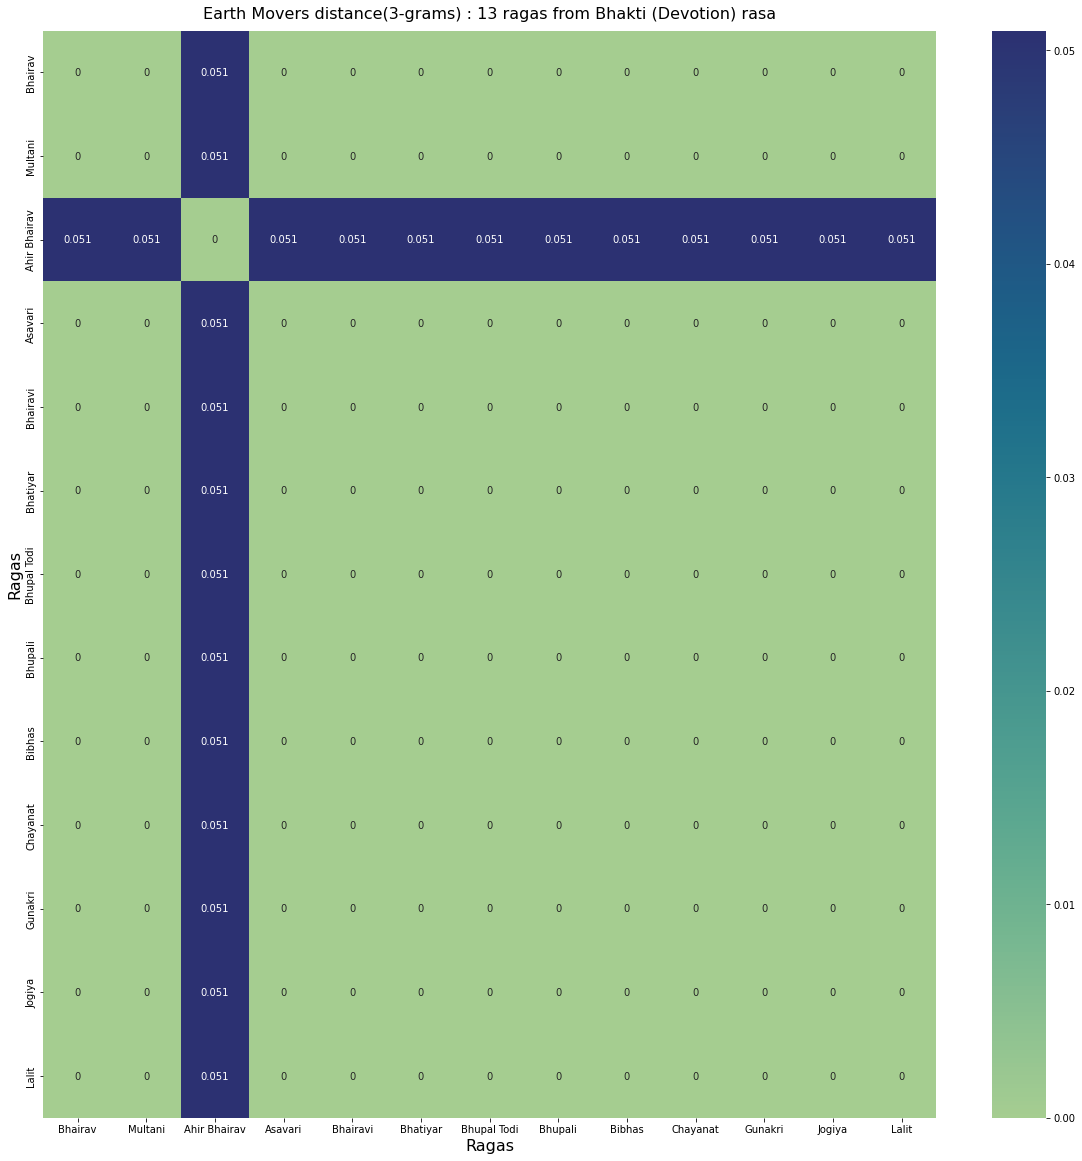

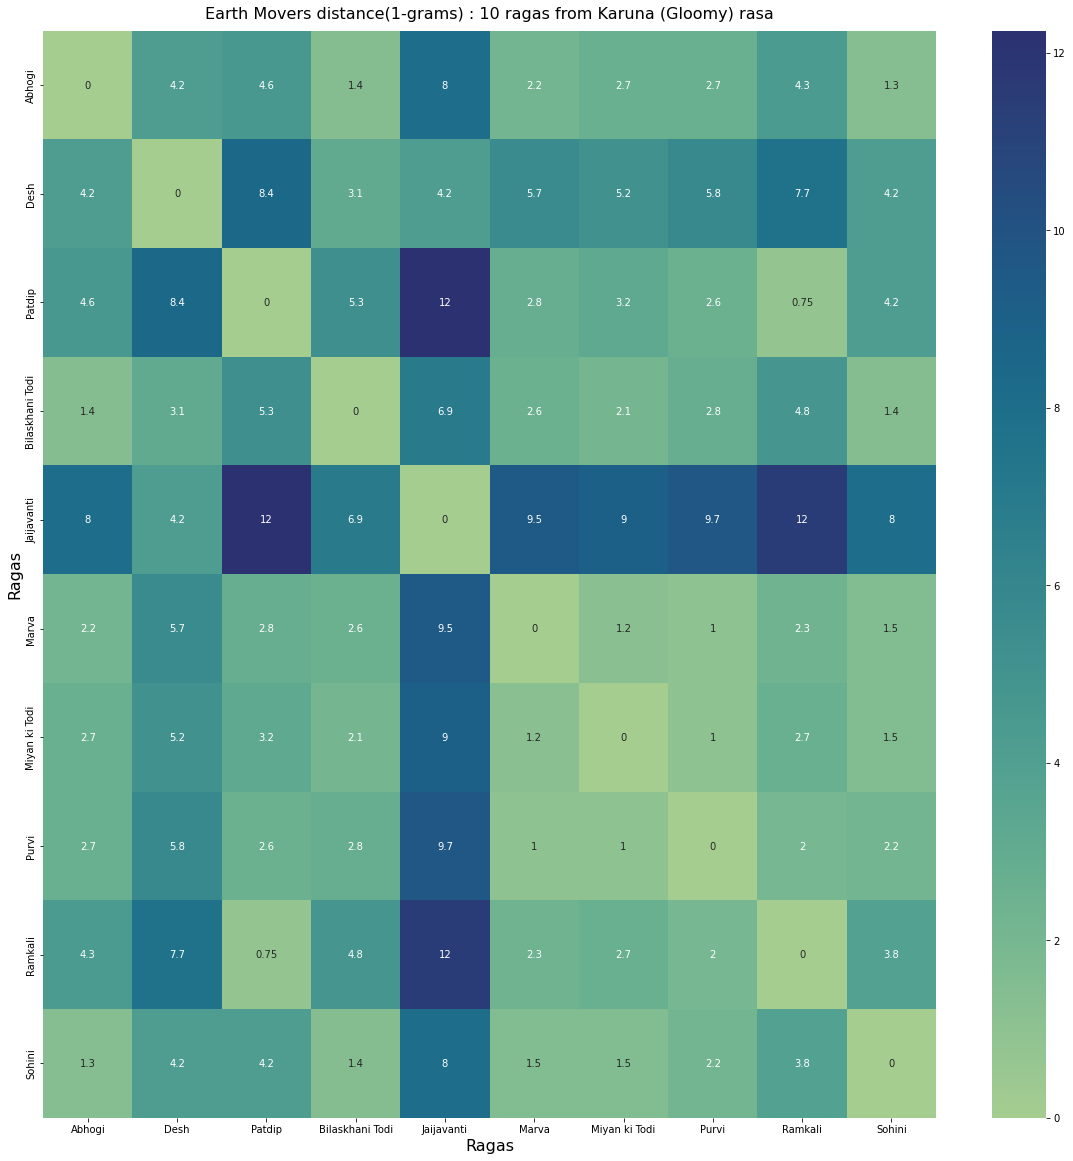

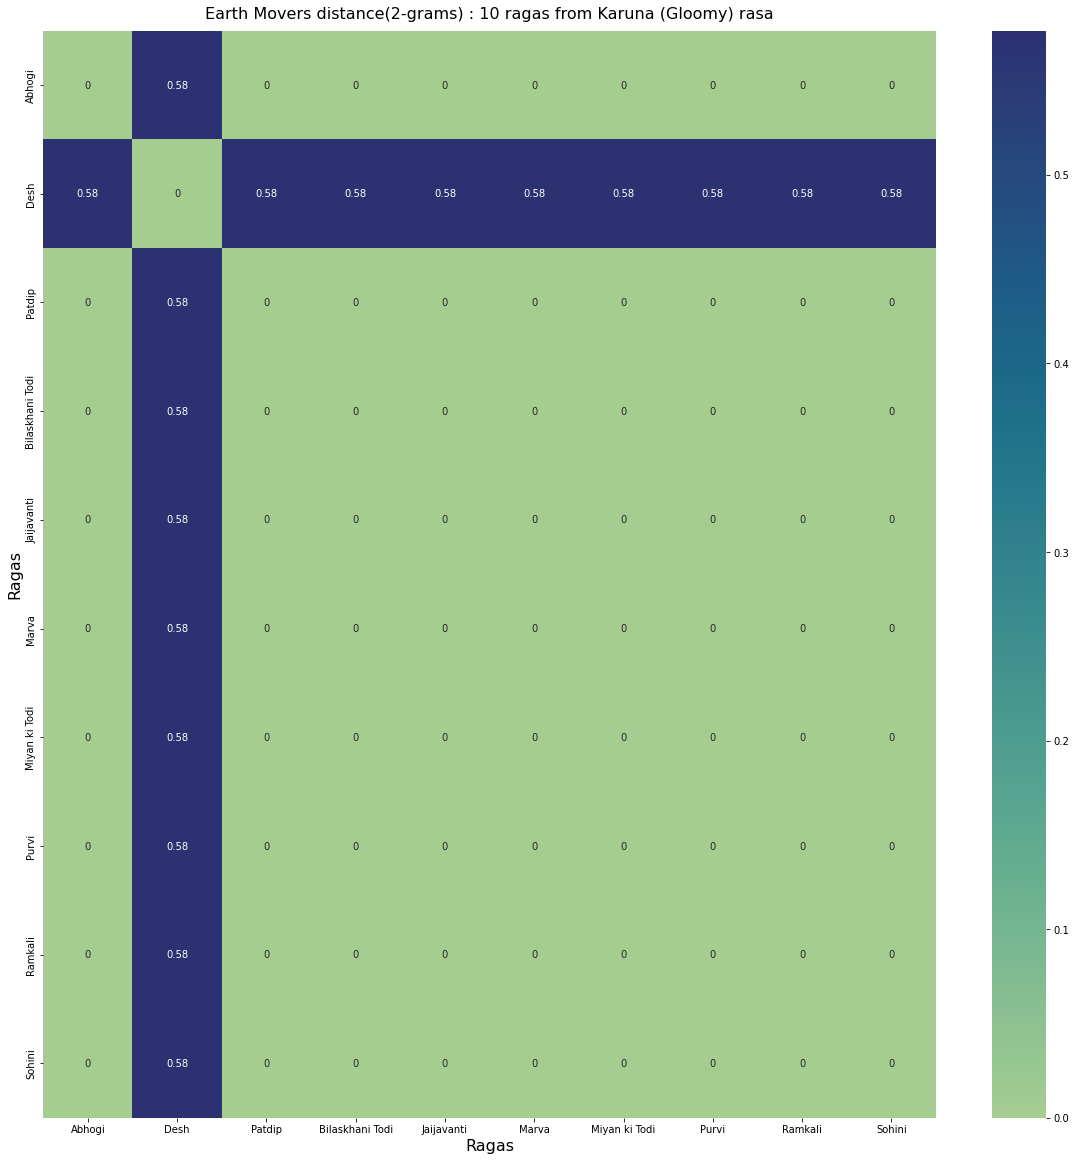

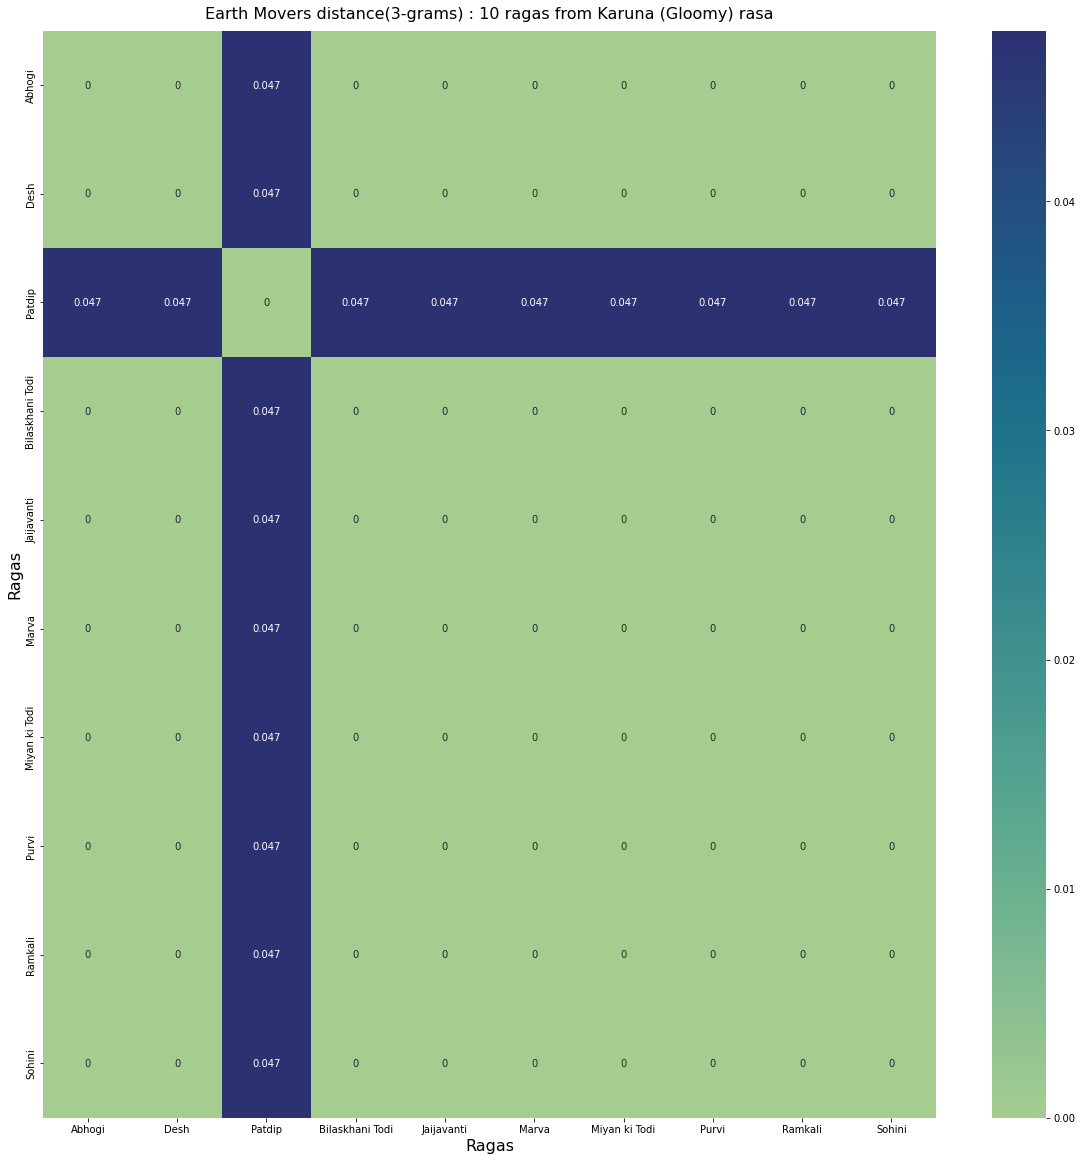

In [108]:
arr = [veer, shringar, adbhut, bhakti2, karuna2]
arr_name = ['Veer (Bravery)', 'Shringar (Love)', 
            'Adbhut (Wonderment)', 'Bhakti (Devotion)', 'Karuna (Gloomy)']
dists = []
dists_two_grams = []
dists_three_grams = []
for i in range(len(arr_name)):
    dists.append(func(arr[i], arr_name[i]))
    dists_two_grams.append(func(arr[i], arr_name[i], 2))
    dists_three_grams.append(func(arr[i], arr_name[i], 3))




In [50]:
dists = np.array(dists) 

In [74]:
np.median(dists[0][np.tril(dists[0])!=0])

3.625000000000001

0


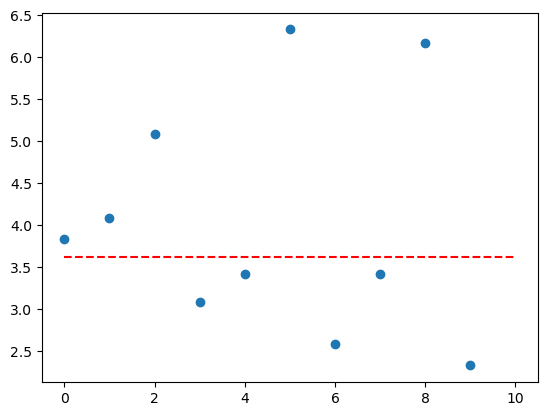

1


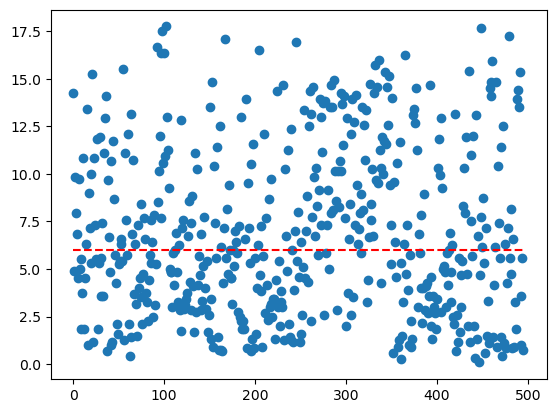

2


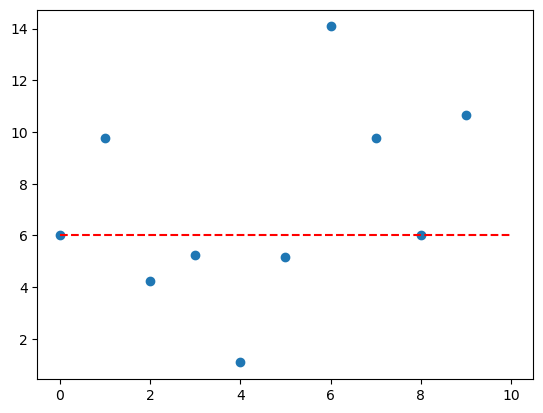

3


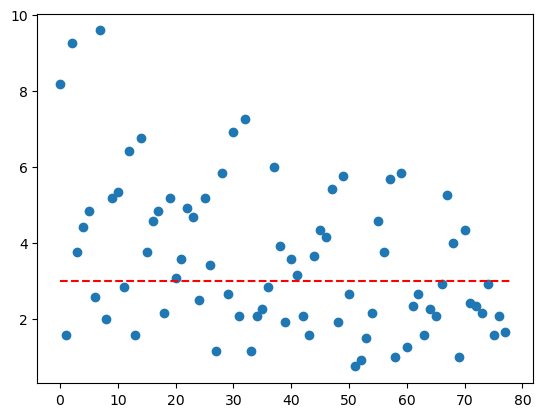

4


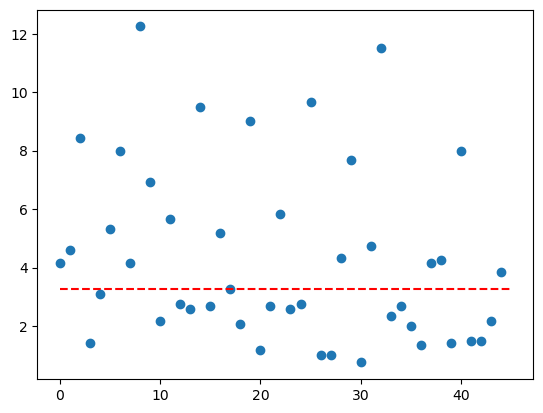

In [50]:
med = []
lower_triangles = []

for i in range(len(dists)):
    print(i)
    plotting = dists[i][np.tril(dists[i])!=0]
    med.append(np.median(plotting))
    lower_triangles.append(plotting)
    plt.plot(plotting, 'o')
    
    plt.hlines(y=np.median(plotting), xmin=0,xmax=len(plotting), color = 'red', linestyles='dashed')
    
#     plt.hlines(y = 1, xmin = 1, xmax = 4)
    plt.show()
#     plt.boxplot(plotting, boxprops=dict(color='red'))
    plt.show()

In [12]:
# for i in range(len(lower_triangles))


[array([3.83333333, 4.08333333, 5.08333333, 3.08333333, 3.41666667,
        6.33333333, 2.58333333, 3.41666667, 6.16666667, 2.33333333]),
 array([14.25      ,  4.91666667,  9.83333333,  7.91666667,  6.83333333,
         4.5       ,  9.75      ,  5.        ,  5.5       ,  1.83333333,
         3.75      , 10.83333333,  1.83333333,  4.5       ,  6.33333333,
        13.41666667,  1.        ,  9.        ,  7.16666667,  5.33333333,
        10.        , 15.25      ,  1.16666667, 10.83333333,  7.33333333,
         5.5       , 11.83333333,  1.83333333,  5.33333333, 11.91666667,
         3.58333333,  5.58333333,  7.41666667,  3.58333333, 11.08333333,
        12.91666667, 14.08333333,  0.66666667,  9.66666667,  6.66666667,
         4.83333333, 10.66666667,  1.        ,  1.16666667, 11.75      ,
         8.66666667,  5.75      ,  4.25      ,  2.08333333,  1.58333333,
         5.25      ,  5.41666667,  6.58333333,  6.33333333,  5.41666667,
        15.5       ,  1.25      , 11.08333333,  7.58333333,

Text(0.5, 0, 'Rasas')

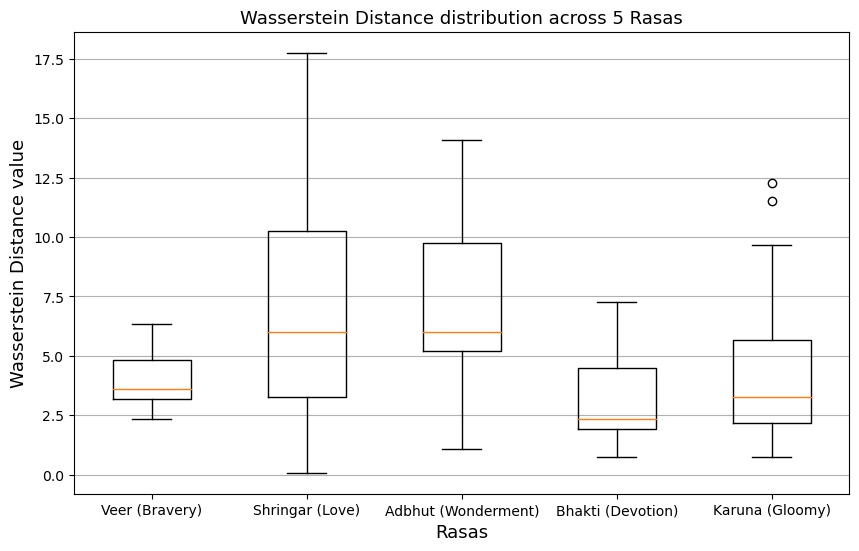

In [46]:
plt.figure(figsize=(10, 6))
plt.boxplot(lower_triangles)
plt.xticks([1,2,3,4, 5],arr_name)
plt.grid(axis = 'y')
plt.title('Wasserstein Distance distribution across 5 Rasas', fontsize=13)
plt.ylabel('Wasserstein Distance value', fontsize=13)
plt.xlabel('Rasas', fontsize=13)



Text(0.5, 0, 'Rasas')

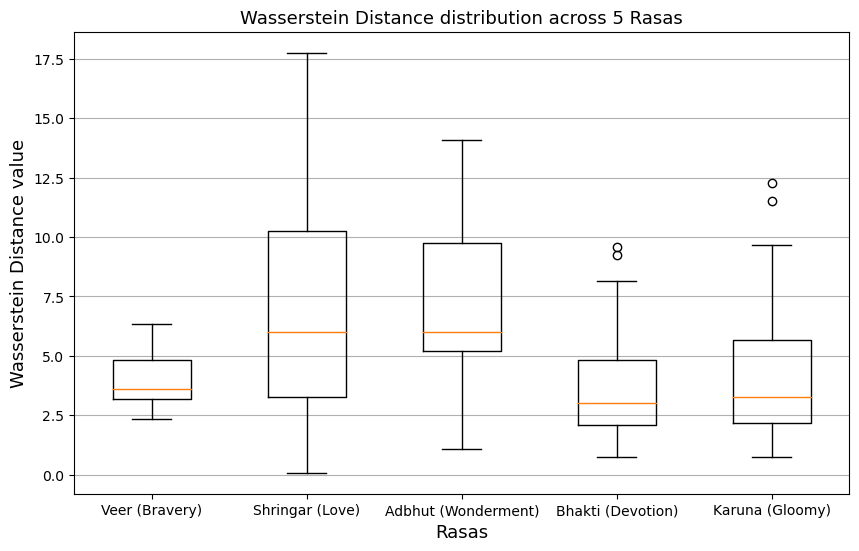

In [51]:
plt.figure(figsize=(10, 6))
plt.boxplot(lower_triangles)
plt.xticks([1,2,3,4, 5],arr_name)
plt.grid(axis = 'y')
plt.title('Wasserstein Distance distribution across 5 Rasas', fontsize=13)
plt.ylabel('Wasserstein Distance value', fontsize=13)
plt.xlabel('Rasas', fontsize=13)



In [ ]:
Monte Carlo simulation of randomly selecting

In [16]:
#Find the variance of the two groups 

np.var(lower_triangles[0]), np.var(lower_triangles[1])
#Here, the ratio is greater than 4: 1 hence the variance is different.
#So, we can apply Welch’s t-test. Assuming normal distribution.
#Our IV is rasa, discrete with >2 groups, 


(1.7641666666666673, 19.465107508816047)

In [52]:
import scipy.stats as stats
df=pd.DataFrame(columns=['Rasa1', 'Rasa2', 'Test_Statistic', 'Pvalue'])

count = 0
for i in range(len(lower_triangles)):
    for j in range(len(lower_triangles)):
        if i<j:
            
            test_stat, pval=stats.ttest_ind(lower_triangles[i], lower_triangles[j], equal_var = False)
            print("Rasa:", i,"Rasa:", j," Test statistic:",test_stat, 'pval:',pval)
            df.loc[count]=[arr_name[i],arr_name[j],test_stat, pval]
            count+=1

Rasa: 0 Rasa: 1  Test statistic: -5.892283104645893 pval: 5.363611807266293e-05
Rasa: 0 Rasa: 2  Test statistic: -2.477979829189002 pval: 0.029982337591197998
Rasa: 0 Rasa: 3  Test statistic: 0.9596403958410029 pval: 0.35348218360509176
Rasa: 0 Rasa: 4  Test statistic: -0.4425834465144524 pval: 0.6612338416307746
Rasa: 1 Rasa: 2  Test statistic: -0.2536473755203032 pval: 0.8051730735766438
Rasa: 1 Rasa: 3  Test statistic: 11.177907333033714 pval: 2.2932116973765694e-23
Rasa: 1 Rasa: 4  Test statistic: 5.298567396587129 pval: 1.5860874748215974e-06
Rasa: 2 Rasa: 3  Test statistic: 2.987191063102681 pval: 0.01419292495766001
Rasa: 2 Rasa: 4  Test statistic: 2.2593131592628977 pval: 0.04396836775235062
Rasa: 3 Rasa: 4  Test statistic: -1.51429436215734 pval: 0.1346931552955697


### 